# CH4 Time Series Modeling
**Objective**: Develop a SARIMA model for forecasting atmospheric methane concentration

## Input data
'data/processed/df_model.csv'

## Stages
1. train/test split
2. test data transformations (differencing and log) and perform residuals analyses
3. Auto-ARIMA parameter search
4. TimeSeriesSplit CV parameter search on out-of-sample performance
5. Residuals analyses on best models
6. SARIMA model selection

In [1]:
# enable auto-reloading of imported modules
%load_ext autoreload
%autoreload 2

# ensure src/imports work
import sys
sys.path.append('../')

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox 
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white, het_arch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import time

from src.preprocessing import GasPreprocessor
from src.model_evaluation import in_sample_resid_analysis
from src.model_evaluation import out_of_sample_resid_analysis, summarize_model_assumptions
print('GasPreprocessor imported successfully!')
print('in_sample_resid_analysis imported successfully!')
print('out_of_sample_resid_analysis imported successfully!')
print('summarize_model_assumptions imported successfully!')

GasPreprocessor imported successfully!
in_sample_resid_analysis imported successfully!
out_of_sample_resid_analysis imported successfully!
summarize_model_assumptions imported successfully!


# Load the data

In [3]:
# load cleaned data

df = pd.read_csv(
    '../data/processed/df_model.csv',
    index_col=0,
    parse_dates=True,
    dtype={'value': float, 'value_unc': float, 'qcflag': str}
)

print(f'loaded {len(df)} records')
display(df.head())

loaded 1746 records


,value,value_unc,qcflag
1991-01-04,1719.845,2.71,...
1991-01-11,1736.940,2.71,...
1991-01-18,1728.335,2.71,...
1991-01-25,1716.080,2.71,...
1991-02-01,1727.430,2.71,...


In [4]:
df.tail()

,value,value_unc,qcflag
2024-11-25,1970.8250,0.575,...
2024-12-06,1959.4500,0.575,...
2024-12-17,1923.0025,0.575,...
2024-12-24,1952.3800,0.575,...
2024-12-31,1977.4450,0.575,.S.


## Resample full dataset

The full dataset will be resampled to weekly ('W') ahead of train/test split and subsequent preprocessing because:
1.  The mode of the observations after aggregation (see notebook 2_ch4_eda) is 52 observations/year
2.  Previous efforts to resample the train and test sets separtely, as part of the GasPreprocessor class functionality, has led to problems with the gap between the last train set value and the first test set value.  I have experienced gaps that are either too great (2 week gap) or are non-existant such that the last train datapoint date is the same as the first test set datapoint date, which is data leakage.

In [5]:
df_float = df[['value', 'value_unc']].resample('W').mean()
df_obj = df[['qcflag']].resample('W').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

df_resamp = pd.concat([df_float, df_obj], axis=1)

In [6]:
df_resamp.head()

,value,value_unc,qcflag
1991-01-06,1719.845,2.71,...
1991-01-13,1736.940,2.71,...
1991-01-20,1728.335,2.71,...
1991-01-27,1716.080,2.71,...
1991-02-03,1727.430,2.71,...


In [7]:
# compare indexes to note change in datetime indexes and frequency

print('df first 5 indexes:')
print(df.index[:5])
print('\ndf_resamp firt 5 indexes:')
print(df_resamp.index[:5])

df first 5 indexes:
DatetimeIndex(['1991-01-04', '1991-01-11', '1991-01-18', '1991-01-25',
               '1991-02-01'],
              dtype='datetime64[ns]', freq=None)

df_resamp firt 5 indexes:
DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', freq='W-SUN')


In [8]:
# inspect resampled data for NaNs
print('Number of NaN values in each df_samp feature')
print('value: ', df_resamp['value'].isna().sum())
print('value_unc: ', df_resamp['value_unc'].isna().sum())
print('qcflag: ', df_resamp['qcflag'].isna().sum())

Number of NaN values in each df_samp feature
value:  47
value_unc:  47
qcflag:  47


## Rename 'value' to 'CH4' for GasPreprocessor class

In [9]:
df_resamp = df_resamp.rename(columns={'value': 'CH4'})

In [10]:
df_resamp.head()

,CH4,value_unc,qcflag
1991-01-06,1719.845,2.71,...
1991-01-13,1736.940,2.71,...
1991-01-20,1728.335,2.71,...
1991-01-27,1716.080,2.71,...
1991-02-03,1727.430,2.71,...


# Train/test split

## Split the data and inspect

In [11]:
test_size = 52 # one year of weekly data

train = df_resamp.iloc[:-test_size]
test = df_resamp.iloc[-test_size:]

In [12]:
print(f'Train data: {train.shape[0]} data points, from {train.index.min()} to {train.index.max()}')
print(f'Test data: {test.shape[0]} data points, from {test.index.min()} to {test.index.max()}')

Train data: 1723 data points, from 1991-01-06 00:00:00 to 2024-01-07 00:00:00
Test data: 52 data points, from 2024-01-14 00:00:00 to 2025-01-05 00:00:00


In [13]:
# check the data frequency

print(f'Train data frequency: {train.index.freq}')
print(f'Test data frequency: {test.index.freq}')

Train data frequency: <Week: weekday=6>
Test data frequency: <Week: weekday=6>


<Week: weekday=6> == W-SUN

## Inspect the gap between train and test sets

In [14]:
# Check the last training point vs first test point

print('Last training date:', train.index[-1])
print('First test date:', test.index[0])
print('\nGap between train end and test start:', test.index[0] - train.index[-1])

Last training date: 2024-01-07 00:00:00
First test date: 2024-01-14 00:00:00

Gap between train end and test start: 7 days 00:00:00


## Visually confirm the data split

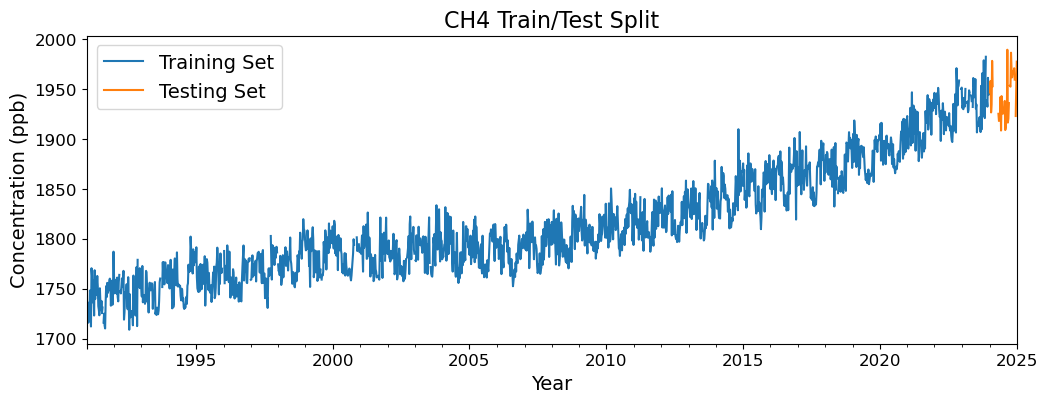

In [15]:
# visually confirm the data split

fig, ax = plt.subplots(figsize=(12,4))
train['CH4'].plot(ax=ax, label='Training Set')
test['CH4'].plot(ax=ax, label='Testing Set')

ax.set_title('CH4 Train/Test Split', fontsize=16)
ax.set_ylabel('Concentration (ppb)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=14)
plt.show()

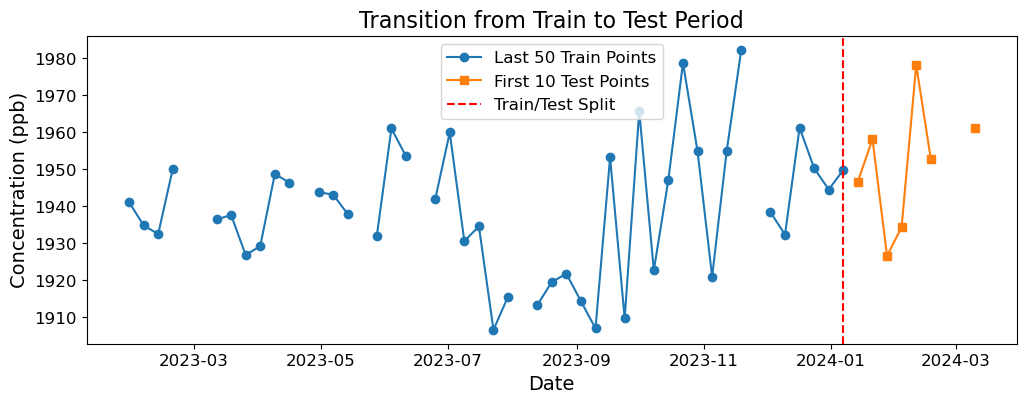

In [16]:
# Plot the transition from train to test

plt.figure(figsize=(12,4))
plt.plot(train['CH4'].index[-50:], train['CH4'].values[-50:], 
         label='Last 50 Train Points', marker='o')
plt.plot(test['CH4'].index[:10], test['CH4'].values[:10],
         label='First 10 Test Points', marker='s')
plt.axvline(x=train['CH4'].index[-1], color='red', linestyle='--', 
            label='Train/Test Split')

plt.title('Transition from Train to Test Period', fontsize=16)
plt.ylabel('Concentration (ppb)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(loc='upper center',fontsize=12)
plt.show()

# Proprocessing and EDA of train set


[INFO] Fitting preprocessing for CH4
[INFO] Starting fit() for CH4 | Resample freq = None (using existing index)
Raw data: 1723 points, 37 NaNs
Trimmed data: 1723 points, 37 NaNs
Data range after trimming: 1991-01-06 00:00:00 to 2024-01-07 00:00:00
After resampling: 1723 points, 37 NaNs
[INFO] Found 29 potential outliers using robust STL residuals.
After outlier removal: 1723 points, 66 NaNs
After smoothing: 1723 points, 0 NaNs
After interpolation: 1723 points, 0 NaNs


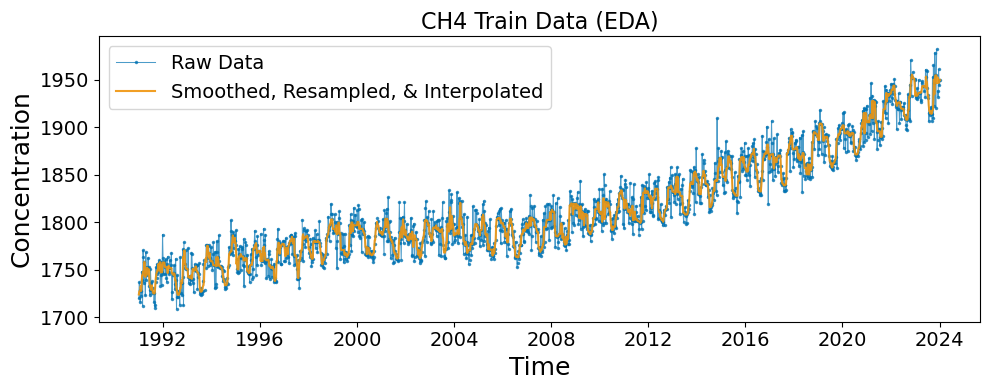

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.3025
ADF p-value 0.9251
ADF critical values: {'1%': -3.4341979376824896, '5%': -2.8632396483453024, '10%': -2.5676748474801885}

KPSS statistic 5.8098
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:489: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


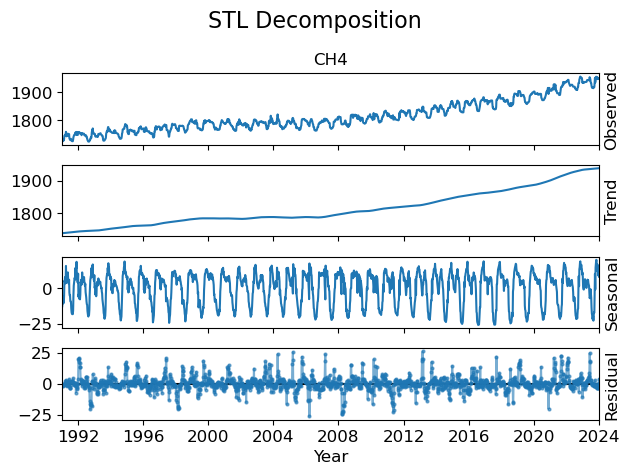

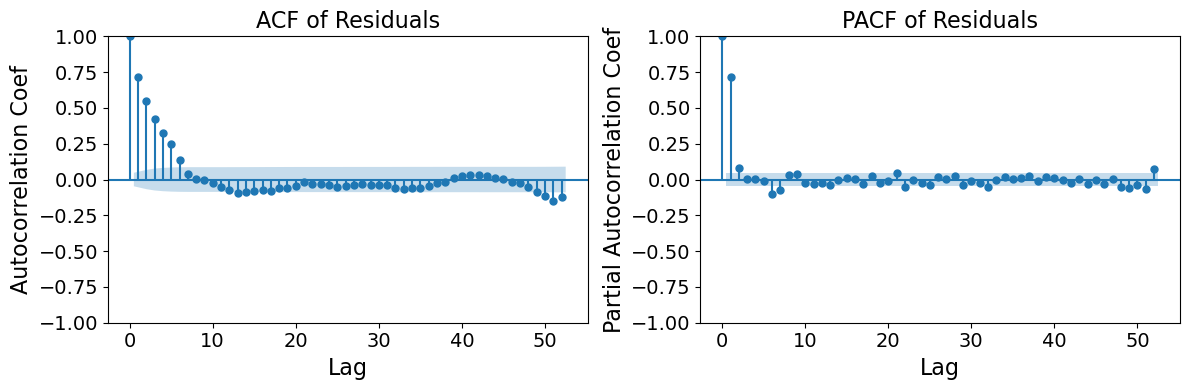


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.5482
No heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.7185
No heteroscedasticity detected (White test)
Adjusting test set dates to be contiguous with train set
[INFO] Dropping overlapping test point at 2024-01-07 00:00:00 (train end = 2024-01-07 00:00:00)


In [21]:
# fit and transform the training data to the GasPreprocessor class
# transform the test data using the fitted preprocessor

preprocessor = GasPreprocessor(
    gas_name='CH4', 
    iqr_factor=3.0,
    seasonal_period=52,
    do_eda=True
)

train_preprocessed = preprocessor.fit_transform(
    train[['CH4']], 
    custom_title = 'CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
test_preprocessed = preprocessor.transform(test[['CH4']])

In [22]:
train_preprocessed.tail()

2023-12-10    1947.39875
2023-12-17    1947.17250
2023-12-24    1947.17250
2023-12-31    1949.82750
2024-01-07    1950.05375
Freq: W-SUN, Name: CH4, dtype: float64

In [23]:
test_preprocessed.head()

2024-01-14    1956.96000
2024-01-21    1925.22750
2024-01-28    1928.19750
2024-02-04    1929.60000
2024-02-11    1928.16625
Freq: W-SUN, Name: CH4, dtype: float64

## Determine if seasonal cycles are multiplicative

In [24]:
train_prep_df = pd.DataFrame(train_preprocessed)
train_prep_df

,CH4
1991-01-06,1724.09000
1991-01-13,1727.43000
1991-01-20,1724.99750
1991-01-27,1727.43000
1991-02-03,1728.33500
...,...
2023-12-10,1947.39875
2023-12-17,1947.17250
2023-12-24,1947.17250
2023-12-31,1949.82750


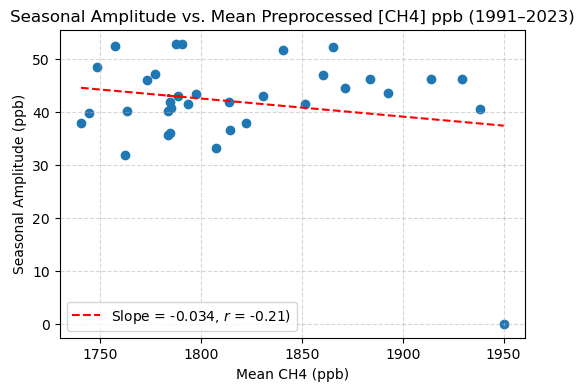

In [25]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration for the preprocessed train data.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 


train_prep_df = train_prep_df.copy()
train_prep_df['year'] = train_prep_df.index.year

# Group by year to compute mean and amplitude
yearly = train_prep_df.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# calculate the correlation coefficient (r)
corr = yearly['mean'].corr(yearly['amplitude'])

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, 
         color='red', 
         linestyle='--', 
         label=f'Slope = {m:.3f}, $r$ = {corr:.2f})')
plt.xlabel('Mean CH4 (ppb)')
plt.ylabel('Seasonal Amplitude (ppb)')
plt.title('Seasonal Amplitude vs. Mean Preprocessed [CH4] ppb (1991–2023)')

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

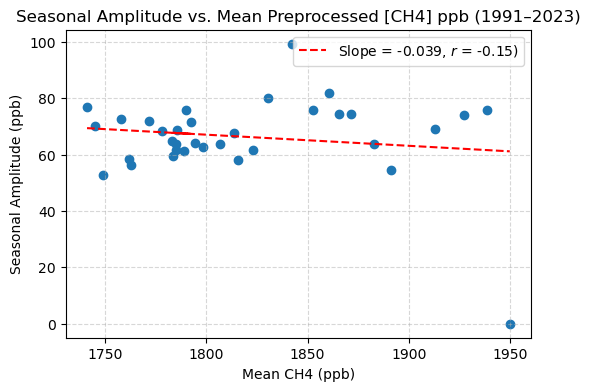

In [29]:
# plot amplitude of the seasonal cycle vs mean CH4 concentration for the preprocessed train data.  
# if the seasonal cycles do not scale with the long term mean, then the cycles are additive
# if the seasonal cycles scale with the mean, then the cycles are multiplicative 



train = train.copy()
train['year'] = train.index.year

# Group by year to compute mean and amplitude
yearly = train.groupby('year')['CH4'].agg(['mean', 'max', 'min'])
yearly['amplitude'] = yearly['max'] - yearly['min']

# calculate the regression line
x = yearly['mean'].values
y = yearly['amplitude'].values
m, b = np.polyfit(x, y, 1)

# calculate the correlation coefficient (r)
corr = yearly['mean'].corr(yearly['amplitude'])

# Scatter plot: mean vs amplitude
plt.figure(figsize=(6,4))
plt.scatter(yearly['mean'], yearly['amplitude'])
plt.plot(x, m*x + b, 
         color='red', 
         linestyle='--', 
         label=f'Slope = {m:.3f}, $r$ = {corr:.2f})')
plt.xlabel('Mean CH4 (ppb)')
plt.ylabel('Seasonal Amplitude (ppb)')
plt.title('Seasonal Amplitude vs. Mean Preprocessed [CH4] ppb (1991–2023)')

# plt.plot(corr)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

**Interpretation of the seasonal amplitude vs mean preprocessed CH4 plot:**

- slope = 0.022 means that for every 1 unit increase in the mean CH4 level, the seasonal amplitude increases by 0.022 units. Therefore the seasonal cycles are mildly increasing in magnitude as the CH4 concentration increases.

- correlation coefficient (r) = 0.22 suggests a weak to moderate positive linear relationship between the mean CH4 level and seasonal amplitude.  The r^2 value of 0.22^2 = ~ 0.05 indicates that approximately 5% of the variation in the seasonal amplitude is explained by the change in the mean CH4 level.  These results are significantly less compared to the same test performed on the full length, cleaned data (see notebook 3_ch4_preprocessing_eda).  

The positive slope and correlation coefficient (r) suggests that log transformation may be productive toward stabilizing any remaing variance seasonal cycles.  However, the Breusch-Pagan and White tests both find no significant heteroscedasticity in the decomposition residuals, so transformation may not be necessary.  

**Interpretation of the CH4 train series preprocessing and EDA**

Preprocessing the CH4 data appears to be effectively handling resampling, outliers, and interpolation while preserving the seasonality and trend.  

The ADF and KPSS tests confirm that the data series is not stationary, which supports the positive trend and linear regression metrics observed in a previous notebook (see notebook 2_ch4_eda). Therefore, non-seasnal differencing will likely be necessary for good SARIMA model performance.    

STL decomposition provides visual confirmation of the positive trend and the regular, annual seasonality of atomospheric CH4 concentration.  The residuals are analyzed with the ACF and PACF plots.  

The ACF and PACF plots closely resemble those for the full length, cleaned data (see notebook 3_ch4_preprocessing_eda).  The ACF plot has significant spikes at lags 1-5 (not including the first lag (lag 0)) and mildly oscillating behavior.  This suggests that autocorrelation exists in the training set after preprocessing and after the seasonal and trend components are removed.  Also notable is that lag 52 is marginally significant likely indicating seasonal autocorrelation.  

The gradual tapering down of significan lags in the ACF plot and the sharp cut off after lag 1 in the PACF plot suggest an AR(p) model, possibly AR(1).  The marginally significant lag 52 on both ACF and PACF plots suggest a seasonal order as well, possible P and/or Q = 1.  

Heteroscedasticity - both the Breusch-Pagan and White tests indicate that the residuals are not heteroscedastic, which is consistent with what was observed for the full length data.  Furthermore, the seasonal cycle amplitude vs preprocessed CH4 concentration show a very mild positive trend.  So, transformation of the preprocessed data will be tested for possible improvements in modeling performance.  

## Add back value_unc and qcflag

In [60]:
print(train.index[:5])
print(train_preprocessed.index[:5])

DatetimeIndex(['1991-01-04', '1991-01-11', '1991-01-18', '1991-01-25',
               '1991-02-01'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1991-01-06', '1991-01-13', '1991-01-20', '1991-01-27',
               '1991-02-03'],
              dtype='datetime64[ns]', name='date', freq='W-SUN')


In [61]:
# add the preprocessed data as a new column in a DataFrame with value_unc and qcflag

# rename the preprocessed data for the DataFrame column name
train_preprocessed = train_preprocessed.rename('CH4_preprocessed')
test_preprocessed = test_preprocessed.rename('CH4_preprocessed')

# convert to DataFrame
train_preprocessed_df = pd.DataFrame(train_preprocessed)
test_preprocessed_df = pd.DataFrame(test_preprocessed)

# merge metadata (qcflag, value_unc) using nearest original observation, which is the resampled data dates
train_preprocessed_df = pd.merge_asof(
    left=train_preprocessed_df.sort_index(),
    right=train[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D') # nearest +/- 3 days
)

test_preprocessed_df = pd.merge_asof(
    left=test_preprocessed_df.sort_index(),
    right=test[['value_unc', 'qcflag']].sort_index(),
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta('3D')
)

In [62]:
train_preprocessed_df.head()

,CH4_preprocessed,value_unc,qcflag
date,,,
1991-01-06,1724.0900,2.71,...
1991-01-13,1727.4300,2.71,...
1991-01-20,1724.9975,2.71,...
1991-01-27,1727.4300,2.71,...
1991-02-03,1728.3350,2.71,...


In [63]:
train_preprocessed_df.tail()

,CH4_preprocessed,value_unc,qcflag
date,,,
2023-09-24,1922.63750,0.575,.S.
2023-10-01,1947.19500,0.575,...
2023-10-08,1950.20625,0.575,...
2023-10-15,1947.19500,0.575,.S.
2023-10-22,1956.45750,NaN,NaN


The train and test indexes are different from those of train_preprocessed and test_preprocessed because of resampling for regular weekly frequency by the GasPreprocessor class.  Since the GasPreprocessor was fit only on the CH4 (value) column, value_unc and qcflag data remain aligned to the original, irregular timestamps.  

To align these ancillary variables with the new weekly time base, pd.merge_asof() is used to join them to the nearest resampled index. The tolerance=pd.Timedelta('3D') parameter specifies that only matches within ±3 days of each resampled timestamp are accepted.

If no value_unc or qcflag observation exists within that 3-day window, the corresponding cell remains NaN. These NaN values indicate weeks without a nearby original measurement. Because these are ancillary variables used for optional weighting or quality control rather than core model features, the NaNs are left in place for now.

In [64]:
print('train shape:', train.shape)
print('test shape:', test.shape)

print('train_preprocessed shape:', train_preprocessed.shape)
print('test_preprocessed shape:', test_preprocessed.shape)

print('train_preprocessed_df shape:', train_preprocessed_df.shape)
print('test_preprocessed_df shape:', test_preprocessed_df.shape)

train shape: (1694, 3)
test shape: (52, 3)
train_preprocessed shape: (1712,)
test_preprocessed shape: (63,)
train_preprocessed_df shape: (1712, 3)
test_preprocessed_df shape: (63, 3)


The difference in numbers of observations is due to resampling (performed by the Preprocessor class).  

the lengths of the split datasets after preprocessing, specifically due to weekly resampling, reflect their actual time spans, not just the number of data points:

- Train: 1712 weeks (1712 weeks / 52 weeks/year = 32.9 years)
- Test: 63 weeks (63 weeks / 52 weeks/year = 1.2 years)
- The sum of weeks = 1775, which is 34 years. The cleaned CH4 data series spans 1991-2025, which is 34 years.

In [75]:
# Check the last training point vs first test point after preprocessed both series. 

print('Last train date:', train.index[-1])
print('First test date:', test.index[0])
print('Gap between train end and test start:', test.index[0] - train.index[-1])

print('\nLast train_df date:', train_df['date'].iloc[-1])
print('First test_df date:', test_df['date'].iloc[0])
print('Gap between train end and test start:', test_df['date'].iloc[0]- train_df['date'].iloc[-1])

print('\nLast train_preprocessed date:', train_preprocessed.index[-1])
print('First test_preprocessed date:', test_preprocessed.index[0])
print('Gap between train end and test start:', test_preprocessed.index[0] - train_preprocessed.index[-1])

print('\nLast train_preprocessed_df date:', train_preprocessed_df.index[-1])
print('First test_preprocessed_df date:', test_preprocessed_df.index[0])
print('Gap between train end and test start:', test_preprocessed_df.index[0] - train_preprocessed_df.index[-1])

Last train date: 2023-10-17 00:00:00
First test date: 2023-10-24 00:00:00
Gap between train end and test start: 7 days 00:00:00

Last train_df date: 2023-10-17 00:00:00
First test_df date: 2023-10-24 00:00:00
Gap between train end and test start: 7 days 00:00:00

Last train_preprocessed date: 2023-10-22 00:00:00
First test_preprocessed date: 2023-10-22 00:00:00
Gap between train end and test start: 0 days 00:00:00

Last train_preprocessed_df date: 2023-10-22 00:00:00
First test_preprocessed_df date: 2023-10-22 00:00:00
Gap between train end and test start: 0 days 00:00:00


# Save the Preprocessed Train and Test data

In [21]:
from pathlib import Path

# define output path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [22]:
# save the preprocessed train data
output_path = output_dir / 'CH4_train_preprocessed.csv'
(
    CH4_train_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

# save the preprocessed test data
output_path = output_dir / 'CH4_test_preprocessed.csv'
(
    CH4_test_preprocessed
    .reset_index() # convert DateTimeIndex to columns
    .rename(columns={'index': 'date', 0: 'ch4_ppb'})
    .to_csv(output_path, index=False)
)

print(f'CH4_train_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_train_preprocessed.shape}')
print(f'\nCH4_test_preprocessed data saved to:\n{output_path}')
print(f'Shape: {CH4_test_preprocessed.shape}')

CH4_train_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (2112,)

CH4_test_preprocessed data saved to:
..\data\processed\CH4_test_preprocessed.csv
Shape: (63,)


# Preprocessing With Log Transformation


[INFO] Fitting preprocessing for CH4

Trimming 388 leading NaN values
Raw data: 2502 points, 431 NaNs
Trimmed data: 2114 points, 43 NaNs
Data range after trimming: 1983-05-06 00:00:00 to 2023-10-17 00:00:00
[INFO] Applying log transformation.
After resampling: 2112 points, 67 NaNs
[INFO] Found 148 potential outliers using robust STL residuals.
After outlier removal: 2112 points, 215 NaNs
After smoothing: 2112 points, 0 NaNs
After interpolation: 2112 points, 0 NaNs


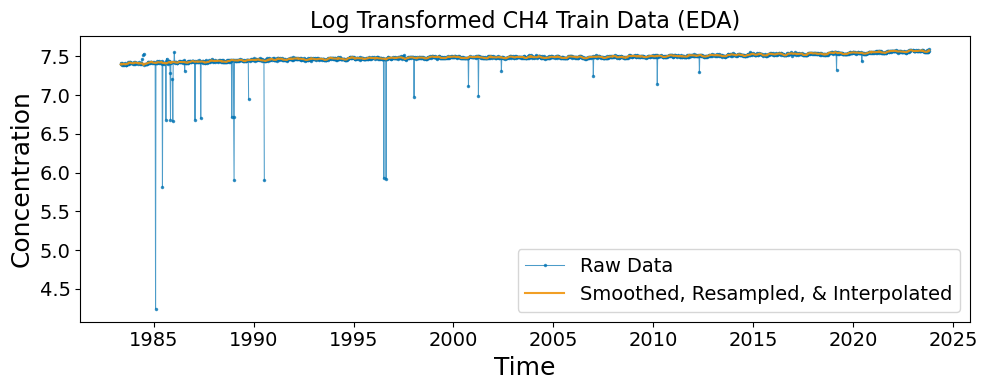

[INFO] EDA stationarity tests on processed data:
ADF and KPSS tests for Processed Data:
ADF statistic -0.9846
ADF p-value 0.7588
ADF critical values: {'1%': -3.433481203206757, '5%': -2.862923230045995, '10%': -2.5675063669901363}

KPSS statistic 6.6824
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the Processed Data time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


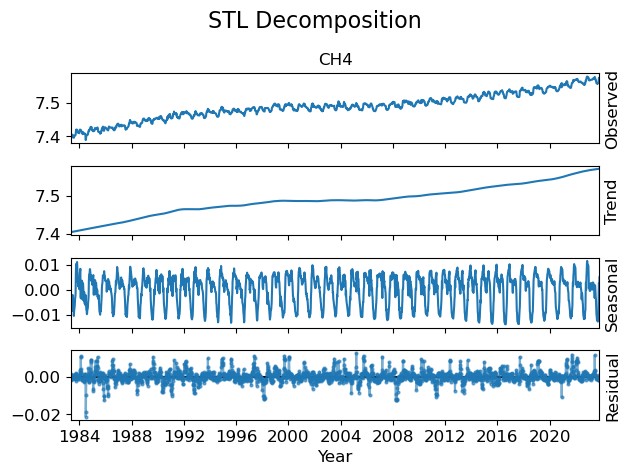

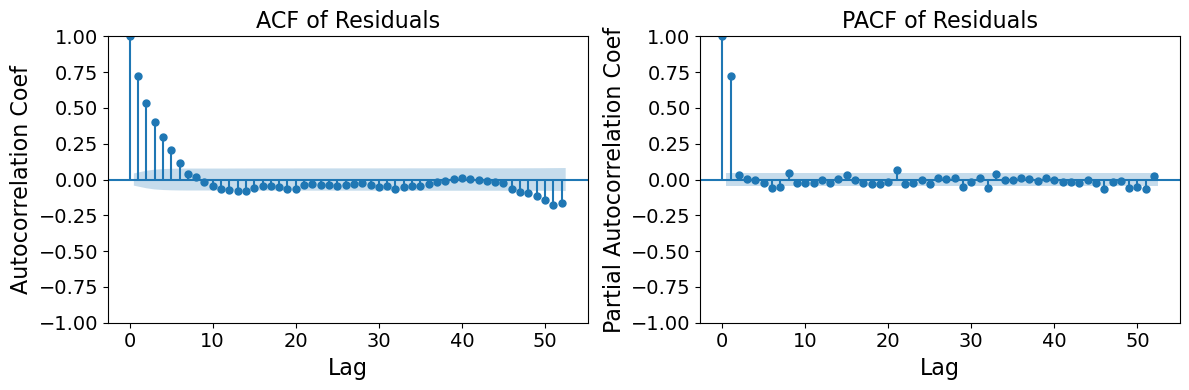


Heteroscedasticity Tests of Residuals
Breusch-Pagan p-value: 0.0126
Heteroscedasticity detected (Breusch-Pagan test)

White Test p-value: 0.0241
Heteroscedasticity detected (White test)

Trimming 388 leading NaN values
Adjusting test set dates to be contiguous with train set


In [23]:
# fit and transform the training data to the GasPreprocessor class, including log transformation to handle heteroscedasticity
# transform the validation and test data using the fitted preprocessor

CH4_train_log_preprocessor = GasPreprocessor(gas_name='CH4', do_eda=True, transformation='log')
CH4_train_log_preprocessed = CH4_train_log_preprocessor.fit_transform(
    CH4_train_df, 
    custom_title = 'Log Transformed CH4 Train Data (EDA)'
)

# transform the test data using the fitted preprocessor
CH4_test_log_preprocessed = CH4_train_log_preprocessor.transform(CH4_test_df)

In [24]:
# verify data structure following transformation and preprocessing 

print('CH4_train shape:', CH4_train_df.shape)
print('CH4_test shape:', CH4_test_df.shape)

print('\nCH4_train_preprocessed shape:', CH4_train_preprocessed.shape)
print('CH4_test_preprocessed shape:', CH4_test_preprocessed.shape)

print('\nCH4_train_log_preprocessed shape:', CH4_train_log_preprocessed.shape)
print('CH4_test_log_preprocessed shape:', CH4_test_log_preprocessed.shape)

CH4_train shape: (2502, 2)
CH4_test shape: (52, 2)

CH4_train_preprocessed shape: (2112,)
CH4_test_preprocessed shape: (63,)

CH4_train_log_preprocessed shape: (2112,)
CH4_test_log_preprocessed shape: (63,)


In [25]:
# Check the last training point vs first test point after log and preprocessing both series. 

print('Last train_log_preprocessed date:', CH4_train_log_preprocessed.index[-1])
print('First test_log_preprocessed date:', CH4_test_log_preprocessed.index[0])
print('Gap between train end and test start:', CH4_test_log_preprocessed.index[0] - CH4_train_log_preprocessed.index[-1])

# Check for any NaN values that might cause issues
print(f'\ntrain_log_preprocessed NaN count: {CH4_train_log_preprocessed.isna().sum()}')
print(f'test_log_preprocessed NaN count: {CH4_test_log_preprocessed.isna().sum()}')

# Verify frequency is consistent
print(f'\ntrain_log_preprocessed frequency: {CH4_train_log_preprocessed.index.freq}')
print(f'test_log_preprocessed frequency: {CH4_test_log_preprocessed.index.freq}')

Last train_log_preprocessed date: 2023-10-22 00:00:00
First test_log_preprocessed date: 2023-10-29 00:00:00
Gap between train end and test start: 7 days 00:00:00

train_log_preprocessed NaN count: 0
test_log_preprocessed NaN count: 0

train_log_preprocessed frequency: <Week: weekday=6>
test_log_preprocessed frequency: <Week: weekday=6>


In [26]:
CH4_train_log_preprocessed.head()

date
1983-05-08    7.400810
1983-05-15    7.405599
1983-05-22    7.405599
1983-05-29    7.400810
1983-06-05    7.396486
Freq: W-SUN, Name: CH4, dtype: float64

In [27]:
CH4_test_log_preprocessed.head()

2023-10-29    7.578101
2023-11-05    7.578101
2023-11-12    7.578084
2023-11-19    7.573846
2023-11-26    7.573863
Freq: W-SUN, Name: CH4, dtype: float64

# Save Log and Preprocessed Data for Forecasting

In [28]:
# define path
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True, parents=True)

In [29]:
CH4_train_log_preprocessed.name = 'log_ch4'
CH4_train_log_preprocessed.index.name = 'date'

CH4_test_log_preprocessed.name = 'log_ch4'
CH4_test_log_preprocessed.index.name = 'date'

# save the logged CH4 train data
CH4_train_log_preprocessed.to_csv(
    output_dir / 'CH4_train_log_preprocessed.csv', 
    index = True, # keep the datetime index
    header = True,
    float_format='%.5f'
)
print(f'Saved to: {output_dir / "CH4_train_log_preprocessed.csv"}')

# save the logged CH4 test data
CH4_test_log_preprocessed.to_csv(
    output_dir / 'CH4_test_log_preprocessed.csv', 
    index = True, # keep the datetime index
    header = True,
    float_format='%.5f'
)
print(f'Saved to: {output_dir / "CH4_test_log_preprocessed.csv"}')

Saved to: ..\data\processed\CH4_train_log_preprocessed.csv
Saved to: ..\data\processed\CH4_test_log_preprocessed.csv


**Comparison of Statistical Test Results Before and After Log Transformation of the Training Dataseries:**

- Non-transformed data:

    - ADF statistic: -1.0139, p-value: 0.7481

    - KPSS statistic: 6.6953, p-value: 0.0100

    - result:  the preprocessed data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0196

    - White test p-value: 0.0028

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

- Log-transformed data:

    - ADF statisti:c -0.9846, p-value: 0.7588

    - KPSS statistic: 6.6824, p-value: 0.0100

    - result:  the Processed Data time series is non-stationary according to ADF and KPSS tests.

    - Breusch-Pagan p-value: 0.0126

    - White test p-value: 0.0241

    - result:  Both tests fail to reject the null hypotheses of heteroscedasticity (p < 0.05).

Trend/Seasonality:

Log transformation did not affect stationarity, which is expected and will be addressed through differencing in the SARIMA model.

Heteroscedasticity

The log transformation helped slightly based on the White test result, but there is remaining variance in the residuals.

Autocorrelation patterns:

Prior to log transformation, the ACF plot of STL decomposition residuals shows an oscillatory behavior, which is greatly reduced after log transformation. This is an argument for log transformation since it simplifies the correlation structure and should help tune the SARIMA model orders.

Interpretation of ACF and PACF plots for SARIMA model orders:

The ACF plot shows a gradual decay in autocorrelation coefficient magnitude from lag 1 - 5 indicating non-stationarity requiring non-seasonal differencing. The strong spike at lag 1 in the PACF plot indicates first order differencing (d = 1). The significant lag at 52 is consistent with annual seasonality with weekly time points and suggests the need for seasonal differencing (D = 1).

The gradual decay of lags 1 - 5 of the ACF plot and sharp cut off after lag 1 on the PACF plot indicates an AR(1) process.

model suggestion (thus far): SARIMA(1,1,0)(0,1,0)52

# Difference Preprocessed/Log Transformed Train Data

Origninal series length: 2112
Non-seasonally differenced series length: 2111

[INFO] Stationarity tests on non-seasonally differenced series:
ADF and KPSS tests for non-seasonally differenced:
ADF statistic -15.3258
ADF p-value 0.0000
ADF critical values: {'1%': -3.4334842047036167, '5%': -2.8629245552811486, '10%': -2.5675070726005353}

KPSS statistic 0.0595
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


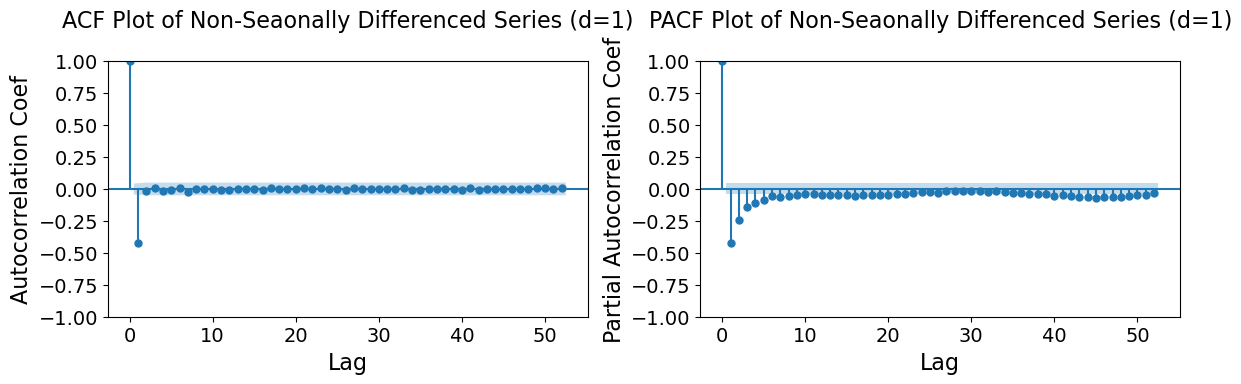

In [30]:
# I will first inspect the residuals of non-seasonally differenced log transformed train data to determine its effectiveness

nsdiffed_series = CH4_train_log_preprocessed.diff(1).dropna()

print(f'Origninal series length: {len(CH4_train_log_preprocessed)}')
print(f'Non-seasonally differenced series length: {len(nsdiffed_series)}')

# stationarity tests
print('\n[INFO] Stationarity tests on non-seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(nsdiffed_series, 'non-seasonally differenced')

# plot ACF and PACF
CH4_train_log_preprocessor.plot_acf_pacf(nsdiffed_series, 'Non-Seaonally Differenced Series (d=1)')

**Interpretation of non-seasonal differencing**

After non-seasonal differencing (d = 1), the log transformed and preprocessed train data is now stationary according to both the ADF and KPSS tests. So, non-seasonal differencing effectively removes the trend.  

ACF and PACF plot results:  The gradual decay seen in the PACF plot along with the sharp cut off observed in the ACF plot indicates a non-seasonal MA(1) process.  


[INFO]: Stationarity tests on seasonally differenced series (D=1 only):
ADF and KPSS tests for seasonally differenced (D=1):
ADF statistic -17.1325
ADF p-value 0.0000
ADF critical values: {'1%': -3.4335345735350664, '5%': -2.862946794168607, '10%': -2.567518913543354}

KPSS statistic 0.3759
KPSS p-value 0.0876
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the seasonally differenced (D=1) time series is likely stationary according to ADF and KPSS tests.



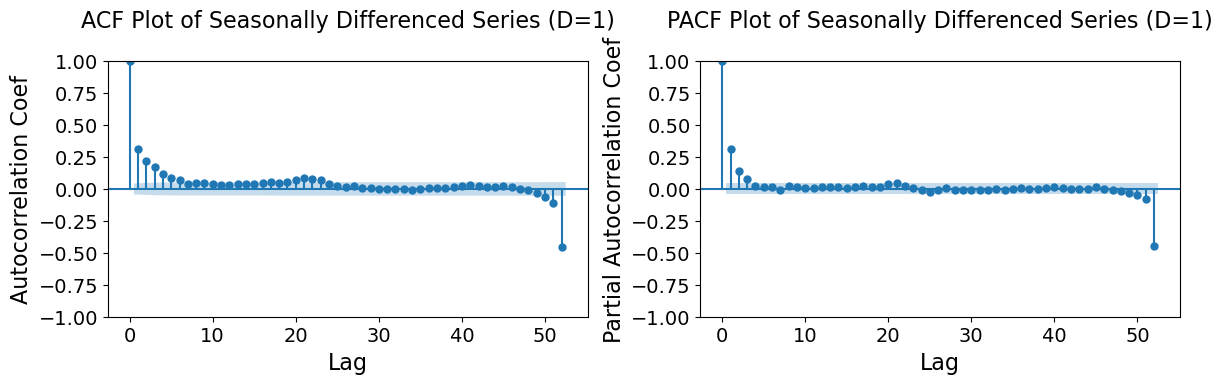

In [31]:
# Test the affect of only seasonal differencing (D=1)

# Apply only seasonal differencing (no non-seasonal)
sdiff = CH4_train_log_preprocessed.diff(52).dropna()

print('\n[INFO]: Stationarity tests on seasonally differenced series (D=1 only):')
CH4_train_log_preprocessor._run_stationarity_tests(sdiff, 'seasonally differenced (D=1)')

# Plot ACF/PACF
CH4_train_log_preprocessor.plot_acf_pacf(sdiff, 'Seasonally Differenced Series (D=1)')

**Interpretation of seasonal differencing**

Seasonal-only differencing also results in a stationary series, suggesting that this differencing removed the seasonality.  The ACF and PACF plots are more complex compared to the non-seasonal-only differencing with gradual decay in both ACF and PACF non-seasonal lags as well as significant spikes at lag 52 (seasonal lag).  


[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:
ADF and KPSS tests for non-seasonally & seasonally differenced:
ADF statistic -16.8519
ADF p-value 0.0000
ADF critical values: {'1%': -3.433564315018763, '5%': -2.862959925476948, '10%': -2.5675259052472796}

KPSS statistic 0.0460
KPSS p-value 0.1000
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the non-seasonally & seasonally differenced time series is likely stationary according to ADF and KPSS tests.



C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\notebooks\..\src\preprocessing.py:423: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


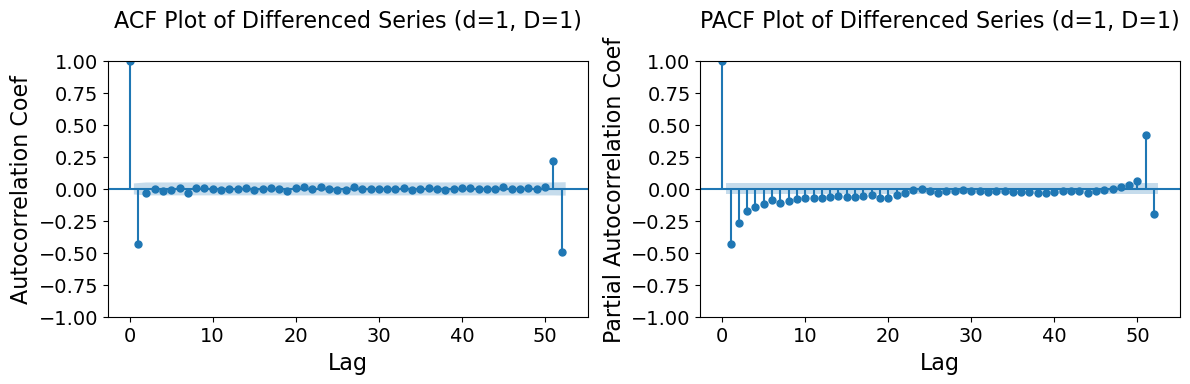

In [32]:
# Test the affect of non-seasonal and seasonal differencing (d=1, D=1)

snsdiffed_series = nsdiffed_series.diff(52).dropna()

# stationarity tests
print('\n[INFO]: Stationarity tests on non-seasonally and seasonally differenced series:')
CH4_train_log_preprocessor._run_stationarity_tests(snsdiffed_series, 'non-seasonally & seasonally differenced')

# ACF and PACF plots
CH4_train_log_preprocessor.plot_acf_pacf(snsdiffed_series, 'Differenced Series (d=1, D=1)')

**Interpretation of differencing results:**

The CH4 data has a positive trend and repeating annual seasonality, necessitating both non-seasonal and seasonal differencing.  The ACF and PACF plot results inform the SARIMA orders.  A gradual decay of significant spikes in the PACF plot and a single significant spike at lag 1 of the ACF plot indicates an MA(1) process.  The PACF plot suggests an AR order of 1-7.     

- non-seasonal orders (p,d,q) = (1-7,1,0-1)

The seasonal spikes at lags 51 and 52:
- ACF plot suggests seaonal MA(1)
- PACF plot suggests seasonal AR(1)
- seasonal orders (P,D,Q,s) = (0-1,1,0-1,52)

# TimeSeriesSplit CV for validation

leaving this code here for the possible purpose of generating all possible combinations of orders based on input values.  

Focus the model search on the d=1, D=1 ACF/PACF patterns

def get_models_from_acf_pacf():
    '''Generate models based on d=1,D=1 ACF/PACF patterns'''
    models = []
    
    # non-seasonal orders based on PACF decay to lag 7
    for p in [1, 2, 3, 4, 5, 6, 7]:
        # non-seasonal MA based on ACF spike at lag 1
        for q in [0, 1]:
            # seasonal orders based on spikes at 51,52
            for P in [0, 1, 2]:
                for Q in [0, 1]:
                    # skip redundant combinations
                    if not (p == 0 and q == 0):
                        models.append({
                            'order': (p, 1, q),
                            'seasonal_order': (P, 1, Q, 52)
                    })
    return models

informed_models = get_models_from_acf_pacf()
print(f'Generated {len(informed_models)} models for evaluation\n')

models_df = pd.DataFrame(informed_models)
print(models_df)

In [33]:
# Run TimeSeriesSplit on the most recent 15 years of train data

recent_years = 15
recent_cutoff = CH4_train_log_preprocessed.index[-1] - pd.DateOffset(years=recent_years)
CH4_recent = CH4_train_log_preprocessed[CH4_train_log_preprocessed.index >= recent_cutoff]

print(f'CH4_recent first date: {CH4_recent.index[0]}')
print(f'CH4_recent final date: {CH4_recent.index[-1]}')

CH4_recent first date: 2008-10-26 00:00:00
CH4_recent final date: 2023-10-22 00:00:00


In [34]:
def get_models_from_acf_pacf():
    '''strategic model set that captures ACF/PACF patterns'''
    models = []
    
    # Test progressive AR complexity (based on PACF decay pattern), without and with MA term
    ar_progression = [
        {'order': (1,1,0), 'seasonal_order': (1,1,1,52)},
        {'order': (2,1,0), 'seasonal_order': (1,1,1,52)},  
        {'order': (3,1,0), 'seasonal_order': (1,1,1,52)},  # Moderate complexity
        {'order': (4,1,0), 'seasonal_order': (1,1,1,52)},  # Higher AR
        {'order': (5,1,0), 'seasonal_order': (1,1,1,52)},  
        {'order': (6,1,0), 'seasonal_order': (1,1,1,52)},  
        {'order': (7,1,0), 'seasonal_order': (1,1,1,52)},  # Maximum from PACF
    ]
    models.extend(ar_progression)
    
    ar_progression_with_ma = [
        {'order': (1,1,1), 'seasonal_order': (1,1,1,52)},
        {'order': (2,1,1), 'seasonal_order': (1,1,1,52)},  
        {'order': (3,1,1), 'seasonal_order': (1,1,1,52)},  # Moderate complexity
        {'order': (4,1,1), 'seasonal_order': (1,1,1,52)},  # Higher AR
        {'order': (5,1,1), 'seasonal_order': (1,1,1,52)},  
        {'order': (6,1,1), 'seasonal_order': (1,1,1,52)},  
        {'order': (7,1,1), 'seasonal_order': (1,1,1,52)},  # Maximum from PACF
    ]
    models.extend(ar_progression_with_ma)
    
    # Test seasonal variations (based on seasonal spikes)
    seasonal_variations = [
        {'order': (1,1,1), 'seasonal_order': (0,1,0,52)},  # No seasonal AR or MA
        {'order': (1,1,1), 'seasonal_order': (0,1,1,52)},  # No seasonal AR
        {'order': (1,1,1), 'seasonal_order': (1,1,0,52)},  # No seasonal MA
        {'order': (1,1,1), 'seasonal_order': (2,1,1,52)},  # Higher seasonal AR
        {'order': (1,1,1), 'seasonal_order': (1,1,2,52)},  # Higher seasonal MA
        {'order': (1,1,1), 'seasonal_order': (2,1,2,52)},  # Higher seasonal AR and MA
    ]
    models.extend(seasonal_variations)
    
    return models

candidate_models = get_models_from_acf_pacf()
print(f'Generated {len(candidate_models)} candidate models')

Generated 20 candidate models


In [35]:
def evaluate_models_tscv(models_list, data, n_splits=5, test_size=52, gap=13): # 3 month gap between train and validation sets to prevent leakage
    '''Evaluate specified candidate models on validation sets'''

    start_time = time.perf_counter()
    
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)
    
    print(f'Evaluating {len(models_list)} models with {n_splits} folds each')
    print(f'Total iterations: {len(models_list) * n_splits}\n')

    # Check split sizes
    for i, (train_idx, val_idx) in enumerate(tscv.split(data)):
        print(f'Fold {i+1}: Train={len(train_idx)} ({len(train_idx)/52:.1f} years), '
              f'Val={len(val_idx)} ({len(val_idx)/52:.1f} years), 'f'Total={len(train_idx) + len(val_idx)}')
    print()
    
    results_summary = []
    
    for params in tqdm(models_list, desc='Models'):
        rmse_scores, mae_scores = [], []
        aic_values, bic_values = [], []
        lb_pval_lag1, lb_pval_lag5, lb_pval_lag10, lb_pval_lag52  = [], [], [], []
        seasonal_strengths = []
        
        successful_folds = 0
        
        for train_idx, val_idx in tscv.split(data):
            train_fold = data.iloc[train_idx]
            val_fold = data.iloc[val_idx]
            
            try:
                model = SARIMAX(
                    train_fold, 
                    order=params['order'], 
                    seasonal_order=params['seasonal_order']
                )

                results = model.fit(
                    disp=False, 
                    maxiter=2000,
                    method='powell',
                    enforce_stationarity=True,
                    enforce_invertibility=True
                )
                
                # Check convergence
                converged = results.mle_retvals.get('converged', False)
                if not converged:
                    continue  # Skip non-converged folds
                
                successful_folds += 1
                
                # Forecast and calculate metrics
                forecast = results.get_forecast(steps=len(val_fold))
                forecast_values = forecast.predicted_mean
                
                rmse = np.sqrt(mean_squared_error(val_fold, forecast_values))
                mae = mean_absolute_error(val_fold, forecast_values)

                # Ljung-Box test with safety check
                if len(results.resid) >= 52:
                    lb_test_comprehensive = acorr_ljungbox(results.resid, lags=[1,5,10,52], return_df=True)
                    lb_pval_lag1.append(lb_test_comprehensive.loc[1, 'lb_pvalue'])
                    lb_pval_lag5.append(lb_test_comprehensive.loc[5, 'lb_pvalue'])
                    lb_pval_lag10.append(lb_test_comprehensive.loc[10, 'lb_pvalue'])
                    lb_pval_lag52.append(lb_test_comprehensive.loc[52, 'lb_pvalue'])
                
                rmse_scores.append(rmse)
                mae_scores.append(mae)
                aic_values.append(results.aic)
                bic_values.append(results.bic)
                
                # Seasonal strength
                if len(forecast_values) >= 52:
                    seasonal_strengths.append(np.std(forecast_values))
                    
            except Exception as e:
                # Skip failed folds
                continue
        
        # Only include models with sufficient successful folds
        if successful_folds >= 3:  # At least 3/5 folds converged
            convergence_rate = successful_folds / n_splits
            
            results_summary.append({
                'order': params['order'],
                'seasonal_order': params['seasonal_order'],
                'successful_folds': successful_folds,
                'convergence_rate': convergence_rate,
                'RMSE_mean': np.mean(rmse_scores) if rmse_scores else np.nan,
                'RMSE_std': np.std(rmse_scores) if rmse_scores else np.nan,
                'MAE_mean': np.mean(mae_scores) if mae_scores else np.nan,
                'AIC_mean': np.mean(aic_values) if aic_values else np.nan,
                'BIC_mean': np.mean(bic_values) if bic_values else np.nan,
                'Seasonal_Strength': np.mean(seasonal_strengths) if seasonal_strengths else 0,
                'LB_lag1_pval_mean': np.mean(lb_pval_lag1) if lb_pval_lag1 else np.nan,
                'LB_lag5_pval_mean': np.mean(lb_pval_lag5) if lb_pval_lag5 else np.nan,
                'LB_lag10_pval_mean': np.mean(lb_pval_lag10) if lb_pval_lag10 else np.nan,
                'LB_lag52_pval_mean': np.mean(lb_pval_lag52) if lb_pval_lag52 else np.nan
            })


    # get the total duration and duration per model
    end_time = time.perf_counter()     
    total_duration = end_time - start_time

    print(f'\nTotal duration: {total_duration / 60:.2f} minutes')
    print(f'Average duration per model: {(total_duration / 60) / len(models_list):.2f} minutes')
        
    return pd.DataFrame(results_summary)

# Run the focused evaluation
print('Starting model evaluation...')
candidate_model_results_df = evaluate_models_tscv(
    models_list=candidate_models,
    data=CH4_train_log_preprocessed,
    n_splits=5,       
    test_size=52,
    gap=13
)

sorted_candidate_models_df = candidate_model_results_df.sort_values(by='RMSE_mean')
print('Candidate models for full CH4_train set sorted by RMSE mean')
print(sorted_candidate_models_df)

Starting model evaluation...
Evaluating 20 models with 5 folds each
Total iterations: 100

Fold 1: Train=1839 (35.4 years), Val=52 (1.0 years), Total=1891
Fold 2: Train=1891 (36.4 years), Val=52 (1.0 years), Total=1943
Fold 3: Train=1943 (37.4 years), Val=52 (1.0 years), Total=1995
Fold 4: Train=1995 (38.4 years), Val=52 (1.0 years), Total=2047
Fold 5: Train=2047 (39.4 years), Val=52 (1.0 years), Total=2099



Models: 100%|██████████| 20/20 [12:50:36<00:00, 2311.85s/it]  



Total duration: 770.64 minutes
Average duration per model: 38.53 minutes
Candidate models for full CH4_train set sorted by RMSE mean
        order seasonal_order  successful_folds  convergence_rate  RMSE_mean  \
3   (4, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009505   
4   (5, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009520   
2   (3, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009534   
6   (7, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009536   
5   (6, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009542   
1   (2, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009626   
0   (1, 1, 0)  (1, 1, 1, 52)                 5               1.0   0.009745   
15  (1, 1, 1)  (0, 1, 1, 52)                 5               1.0   0.010010   
18  (1, 1, 1)  (1, 1, 2, 52)                 5               1.0   0.010038   
7   (1, 1, 1)  (1, 1, 1, 52)                 5               1.0   0.010110 

Important Note:  Powell is the only solver (method) to get good convergence on all models

In [38]:
RMSE_low = 0.009505
RMSE_high = 0.011436
RMSE_std_low = 0.000950
RMSE_std_high = 0.001346

print('=== Model Performance Analysis ===')

# basic RMSE comparison
rmse_range_pct = ((RMSE_high - RMSE_low) / RMSE_low) * 100
print(f'RMSE range: {RMSE_low:.6f} to {RMSE_high:.6f}')
print(f'Best model has {rmse_range_pct:.1f}% lower error than the worst model')

# model stability across folds (cv = coefficient of variation)
cv_best = (RMSE_std_low / RMSE_low) * 100
cv_worst = (RMSE_std_high / RMSE_high) * 100
print(f'\nModel stability (CV = coefficient of variation, lower = more consistent):')
print(f'Best model CV across folds: {cv_best:.1f}%')
print(f'Worst model CV across folds: {cv_worst:.1f}%')

=== Model Performance Analysis ===
RMSE range: 0.009505 to 0.011436
Best model has 20.3% lower error than the worst model

Model stability (CV = coefficient of variation, lower = more consistent):
Best model CV across folds: 10.0%
Worst model CV across folds: 11.8%


I have sorted the model performances based on RMSE, which is the standard deviation of the residuals (prediction errors train vs validation sets)

The model with the lowest mean RMSE has ~20% lower error compared to the model with the highest mean RMSE, which is a moderate difference that may be meaningul. However, the narrow range of error (0.010205 to 0.011192) suggests that all models are performing reasonably well on the 5 fold cross validation sets.  

The RMSE_std reports on the consistency/stability of model performance across different time periods (folds).  Models with a coefficient of variation < 10% are considered to have good stability (>15% may be problematic).  So, even the worst model has reasonably good stability across multiple validation sets.  

Note: seasonal_strength measures how much seasonal variation that the forecast captures.  The magnitude of the values relate to the strength of the seasonal pattern (higher value means greater seasonal pattern).  There is good consistency in the seasonal_strength score across all models indicating that all do a reasonably good jop at detecting seasonal patterns.  But, the low Ljung-Box p values (0 << 0.05) for all models indicate remaining seasonal structure in the residuals.  

The low Ljung-Box mean p values suggest that the seasonal orders (P,Q) may need to be increased to capture more/all of the seasonal patterns.  

In [39]:
# Apply the Pareto Frontier Approach to determine the best model on both RMSE and complexity (BIC)
# BIC is used since it penalizes complexity more so than AIC. 

def select_pareto_optimal_models(results_df, complexity_metric='BIC_mean'):
    '''Find models that are optimal in the RMSE-complexity trade-off'''
    # calculate parameter count as complexity measure
    results_df['param_count'] = (
        results_df['order'].apply(lambda x: x[0] + x[2]) + # p,q
        results_df['seasonal_order'].apply(lambda x: x[0] + x[2]) # P,Q
                                 )
    # find Pareto frontier: models where no other model is better in both RMSE and complexity
    pareto_optimal = []

    for _, candidate in results_df.iterrows():
        dominated = False
        for _, other in results_df.iterrows():
            # check if other model is bettter in both dimensions
            if (other['RMSE_mean'] <= candidate['RMSE_mean'] and
                other[complexity_metric] <= candidate[complexity_metric] and
                (other['RMSE_mean'] < candidate['RMSE_mean'] or 
                 other[complexity_metric] < candidate[complexity_metric])):
                dominated = True
                break
        if not dominated:
            pareto_optimal.append(candidate)

    return pd.DataFrame(pareto_optimal).sort_values('RMSE_mean')

# get Pareto-optimal models
pareto_models = select_pareto_optimal_models(candidate_model_results_df)
print('Pareto-optimal models (RMSE vs BIC):')
print(pareto_models[['order', 'seasonal_order', 'RMSE_mean', 'BIC_mean', 'param_count']])

Pareto-optimal models (RMSE vs BIC):
        order seasonal_order  RMSE_mean      BIC_mean  param_count
3   (4, 1, 0)  (1, 1, 1, 52)   0.009505 -11566.234030            6
4   (5, 1, 0)  (1, 1, 1, 52)   0.009520 -11589.413522            7
6   (7, 1, 0)  (1, 1, 1, 52)   0.009536 -11611.865417            9
15  (1, 1, 1)  (0, 1, 1, 52)   0.010010 -11762.959105            3
8   (2, 1, 1)  (1, 1, 1, 52)   0.010236 -11770.658901            5


# Validate Model Finalists on the Test Set

In [40]:
# extract order and seasonal_order from the Pareto frontier results
final_candidates = [
    {'order': row['order'], 'seasonal_order': row['seasonal_order']}
    for _, row in pareto_models.iterrows()
]

def validate_on_test_set(models_list, train_data, test_data, test_data_original):
    '''Validation of final candidate models on the originally held out test set'''

    validation_test_results = []

    for model_params in models_list:
        model = SARIMAX(train_data,
                        order=model_params['order'],
                        seasonal_order=model_params['seasonal_order'])

        results = model.fit(method='powell', disp=False)

        # forecast on the test set
        forecast = results.get_forecast(steps=len(test_data))
        forecast_values = forecast.predicted_mean

        # calculate metrics
        rmse_test = np.sqrt(mean_squared_error(test_data, forecast_values))
        mae_test = mean_absolute_error(test_data, forecast_values)

        # convert final forecasts to original units for interpretation
        forecast_original = np.exp(forecast_values)

        validation_test_results.append({
            'order': model_params['order'],
            'seasonal_order': model_params['seasonal_order'],
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'rmse_test_original': np.sqrt(mean_squared_error(test_data_original, forecast_original)),
            'mae_test_original': mean_absolute_error(test_data_original, forecast_original)
        })

    validation_test_results_df = pd.DataFrame(validation_test_results)
    return validation_test_results_df.sort_values(by='rmse_test')

start_time = time.perf_counter()

test_performance = validate_on_test_set(final_candidates,
                                        CH4_train_log_preprocessed,
                                        CH4_test_log_preprocessed,
                                        CH4_test_preprocessed)

end_time = time.perf_counter()
elapsed_time = end_time - start_time

print('Evaluation metrics for final candidate models')
print('-' * 45)
print(f'Elapsed time: {elapsed_time/60:.2f} minutes\n')
print(test_performance)

Evaluation metrics for final candidate models
---------------------------------------------
Elapsed time: 28.47 minutes

       order seasonal_order  rmse_test  mae_test  rmse_test_original  \
2  (7, 1, 0)  (1, 1, 1, 52)   0.004636  0.003592            8.983181   
1  (5, 1, 0)  (1, 1, 1, 52)   0.004860  0.003523            9.411591   
3  (1, 1, 1)  (0, 1, 1, 52)   0.005097  0.003489            9.868525   
4  (2, 1, 1)  (1, 1, 1, 52)   0.005098  0.003474            9.870663   
0  (4, 1, 0)  (1, 1, 1, 52)   0.005108  0.003570            9.891836   

   mae_test_original  
2           6.971737  
1           6.836281  
3           6.768671  
4           6.739167  
0           6.927335  


In [42]:
# I will compare the top Pareto frontier model, which is also the most complex, with the most simple model
# and the lowest peforming model since it was the highest performing model on the train set.

CH4_test_mean = CH4_test_preprocessed.mean()
print(f'CH4_test mean: {CH4_test_mean:.2f} ppb')
print(f'The (7,1,0)(1,1,1,52) model error is {(8.983181/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')
print(f'The (1,1,1)(0,1,1,52) model error is {(9.868525/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')
print(f'The (4,1,0)(0,1,1,52) model error is {(9.891836/CH4_test_mean) * 100:.2f}% of the mean CH4 test data')

CH4_test mean: 1943.87 ppb
The (7,1,0)(1,1,1,52) model error is 0.46% of the mean CH4 test data
The (1,1,1)(0,1,1,52) model error is 0.51% of the mean CH4 test data
The (4,1,0)(0,1,1,52) model error is 0.51% of the mean CH4 test data


**Interpretation of candidate model results**

error relative to test set data mean:
  - (7,1,0)(1,1,1,52) - 0.46%
  - (1,1,1)(0,1,1,52) - 0.51%
  - (4,1,0)(1,1,1,52) - 0.51%

All three models should be considered for the next round of evaluation.  The most complex model has 7 non-seasonal AR terms, which is consisted with the differecing analysis ACF/PACF plots.  The simplest model is minimally lesser by only 0.05% RMSE and may generalize better for forecasting.  The (4,1,0)(1,1,1,52) model has similar performance to the other two models based on RMSE, performed the best on the in-sample fit, and represents the middle ground of complexity.  

# Evaluate best model in-sample residuals

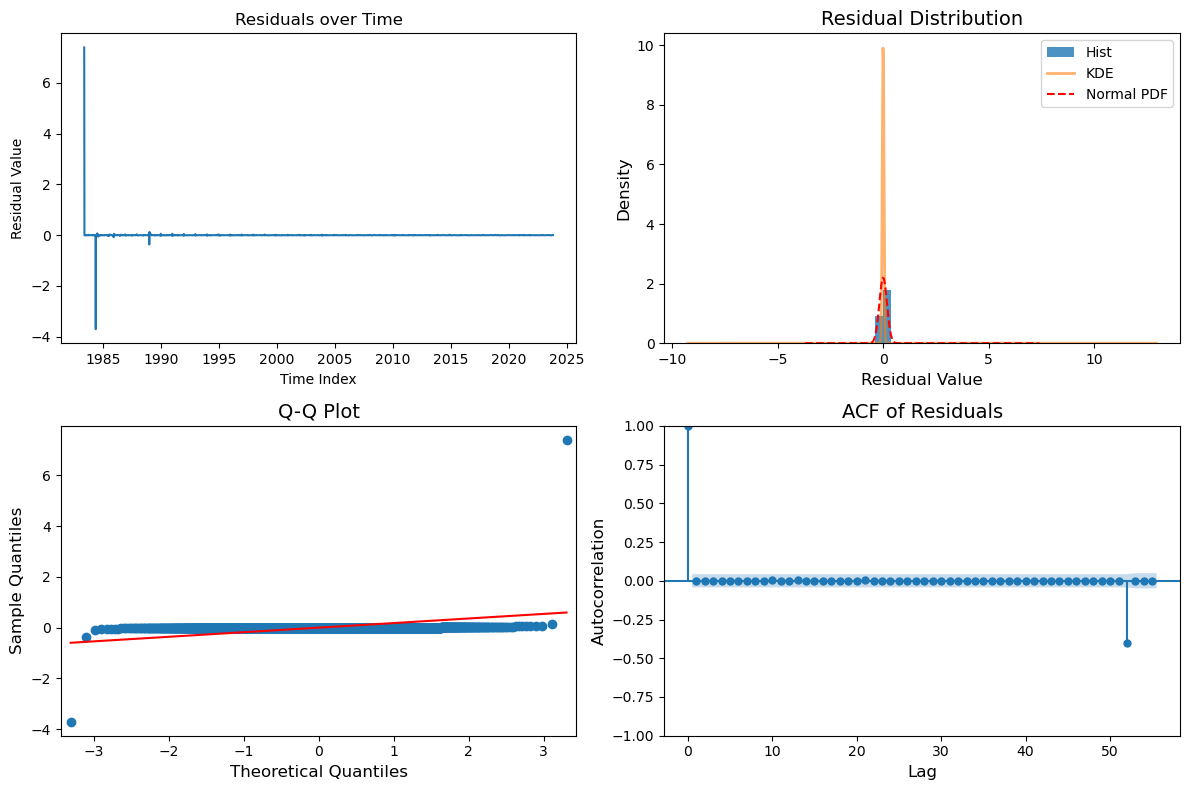


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9634
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.9948
  Lag 4: p-value = 1.0000
  Lag 8: p-value = 1.0000
  Lag 12: p-value = 1.0000
  Lag 26: p-value = 1.0000

Breusch-Pagan p = 0.0371, White p = 0.0035


In [60]:
# Evaluate SARIMA(7,1,0)(1,1,1,52)

sarima710111 = in_sample_resid_analysis(
    CH4_train_log_preprocessed,
    order=(7,1,0),
    seasonal_order=(1,1,1,52),
    run_hetero=True               # BP and White tests for heteroscedasticity
)

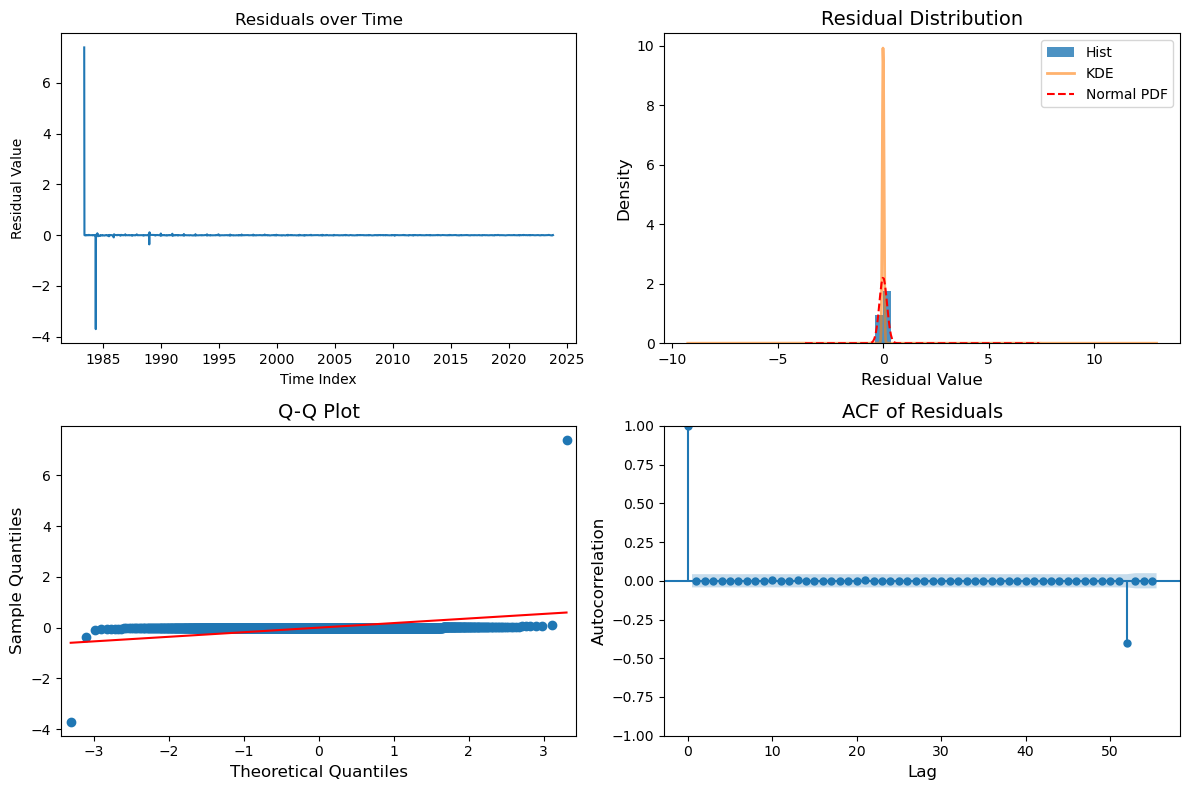


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9651
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.9948
  Lag 4: p-value = 1.0000
  Lag 8: p-value = 1.0000
  Lag 12: p-value = 1.0000
  Lag 26: p-value = 1.0000

Breusch-Pagan p = 0.0371, White p = 0.0035


In [61]:
# Evaluate SARIMA(1,1,1)(0,1,1,52)

sarima111011 = in_sample_resid_analysis(
    CH4_train_log_preprocessed,
    order=(1,1,1),
    seasonal_order=(0,1,1,52),
    run_hetero=True               # BP and White tests for heteroscedasticity
)

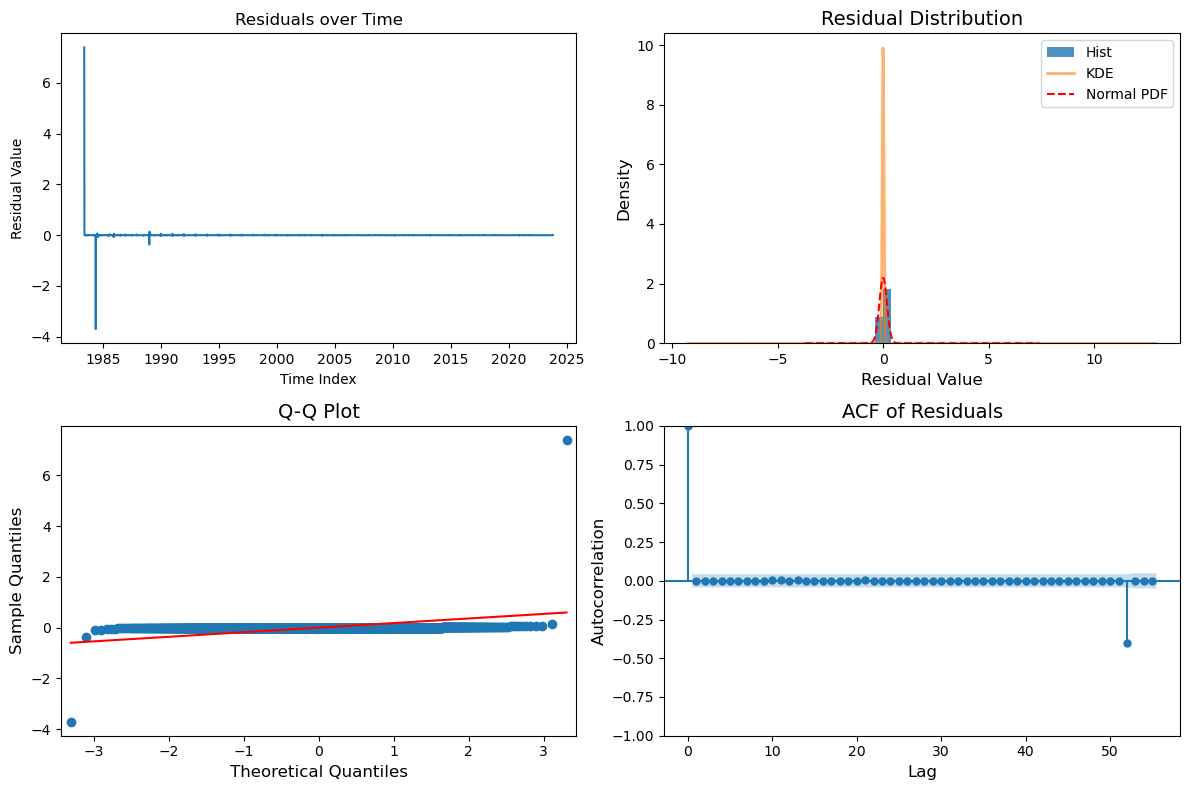


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9635
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.9948
  Lag 4: p-value = 1.0000
  Lag 8: p-value = 1.0000
  Lag 12: p-value = 1.0000
  Lag 26: p-value = 1.0000

Breusch-Pagan p = 0.0370, White p = 0.0035


In [62]:
# Evaluate SARIMA(4,1,0)(1,1,1,52)

sarima410111 = in_sample_resid_analysis(
    CH4_train_log_preprocessed,
    order=(4,1,0),
    seasonal_order=(1,1,1,52),
    run_hetero=True               # BP and White tests for heteroscedasticity
)

**Interpretation of in-sample residual analyses**

all models show approximately the same results, which is likely due to the extreme values seen as spikes in the residuals plot pre-1990s.  These extreme values distort variance, skewness, and kurtosis.
- residuals plot - significant residual value "spikes" seen pre-1990.
- residual distribution - residuals are leptokurtic 
- Q-Q plot - signficant tails on left and right, though seem more right-skewed.
- ACF plot - all lags up to 52 are insignificant.  The significant spike at lag 52 suggests remaining seasonal structure.
- Ljung-Box test for autocorrelation - no signicant autocorrelation at specified lags except for lag 52, as seen in the correlogram.
- ARCH test - no volatility clustering at specified lags.  i.e. there is no statistically significant evidence that the squared residuals up to the specified lags (1, 5, 10, or 52 weeks ago) influence the current period's variance.  Importantly, the lack of evidence for time-dependent volatility clustering means that I likely won't need an ARCH/GARCH model.  
- Breusch-Pagan and White tests - p-values < 0.05 for both tests suggesting the variance of all model's errors is not constant - the residuals show general heteroscedasticity.

# Evaluate best model out-of-sample residuals (predictions vs test set)

=== Out-of-Sample Residual Analysis: SARIMA(7,1,0)(1,1,1,52) ===
Residual mean: -0.00001, std: 0.00467
Skew: -1.022, Kurtosis: 0.159
Shapiro-Wilk normality test: p-value = 0.0000

--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.0000
lag 5: p = 0.0000
lag 10: p = 0.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.0000***
  Lag 4: p-value = 0.0000***
  Lag 8: p-value = 0.0000***
  Lag 12: p-value = 0.0000***
  Lag 26: p-value = 0.0000***


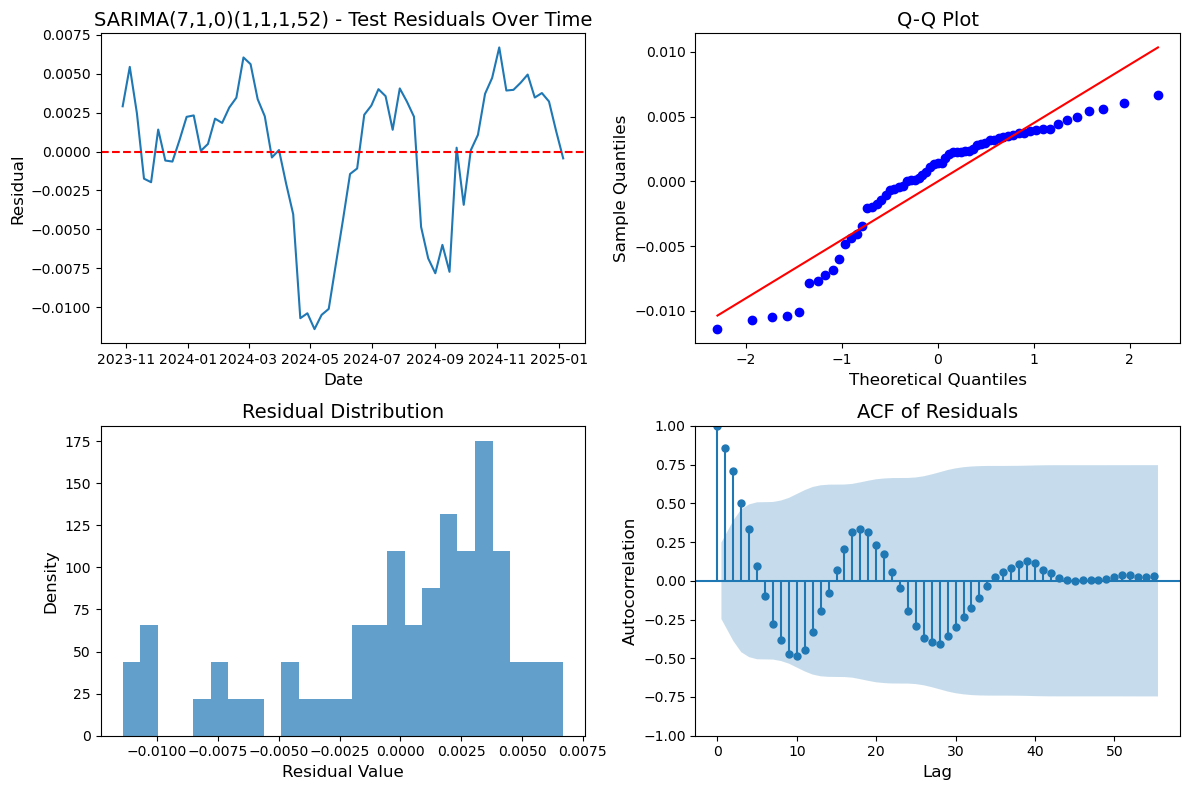

In [68]:
# Evaluate SARIMA(7,1,0)(1,1,1,52) out-of-sample residuals (prediction vs test set)

sarima710111_outsample_resid, sarima710111_outsample_results = out_of_sample_resid_analysis(
    train_data=CH4_train_log_preprocessed,
    test_data=CH4_test_log_preprocessed,
    order=(7,1,0),
    seasonal_order=(1,1,1,52),
    model_name='SARIMA(7,1,0)(1,1,1,52)'
)

=== Out-of-Sample Residual Analysis: SARIMA(1,1,1)(0,1,1,52) ===
Residual mean: -0.00216, std: 0.00459
Skew: -1.054, Kurtosis: 0.226
Shapiro-Wilk normality test: p-value = 0.0000

--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.0000
lag 5: p = 0.0000
lag 10: p = 0.0000
lag 52: p = 0.0000

--- Volatility Clustering Diagnostics ---
Engle's ARCH Test (on squared residuals):
H0: No ARCH effects (constant variance)
  Lag 1: p-value = 0.0000***
  Lag 4: p-value = 0.0000***
  Lag 8: p-value = 0.0000***
  Lag 12: p-value = 0.0000***
  Lag 26: p-value = 0.0000***


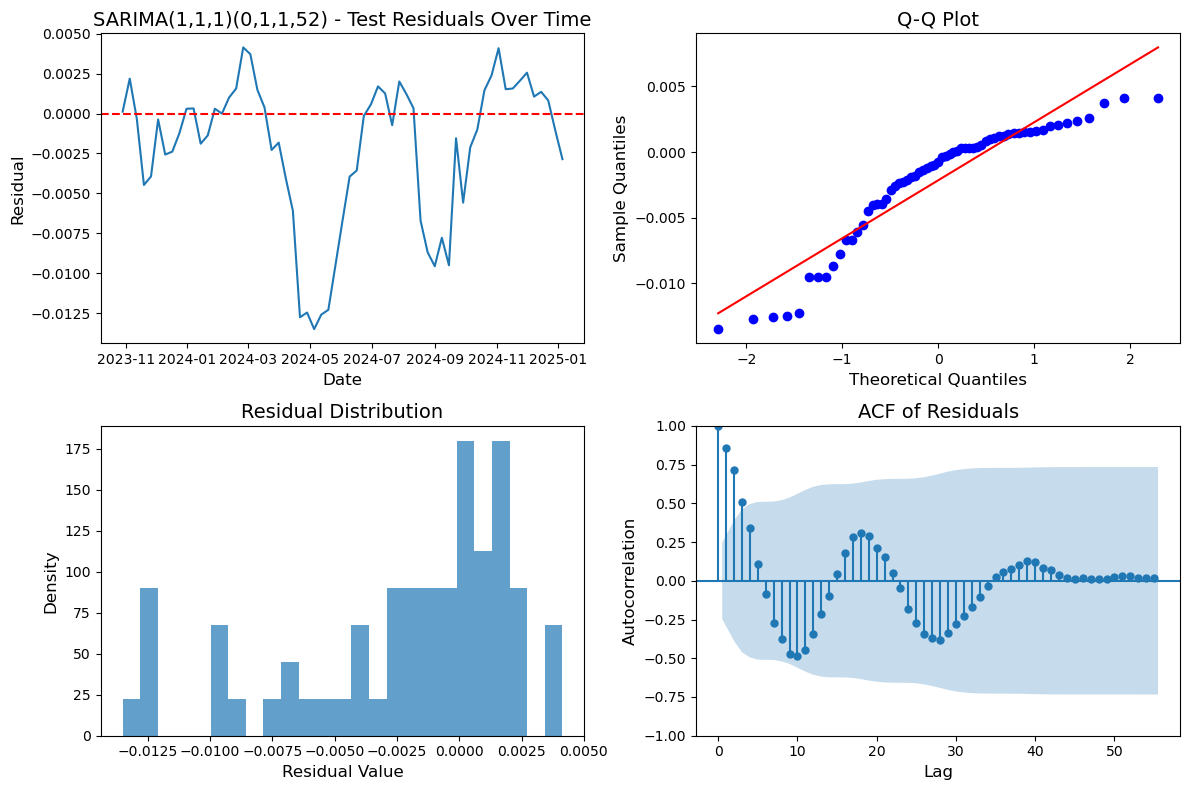

In [69]:
# Evaluate SARIMA(1,1,1)(0,1,1,52) out-of-sample residuals (prediction vs test set)

sarima111011_outsample_resid, sarima111011_outsample_results = out_of_sample_resid_analysis(
    train_data=CH4_train_log_preprocessed,
    test_data=CH4_test_log_preprocessed,
    order=(1,1,1),
    seasonal_order=(0,1,1,52),
    model_name='SARIMA(1,1,1)(0,1,1,52)'
)

I will try a dummy regressor for the SARIMAX model to handle the significant spikes seen in the pre-1990 residuals.  A dummy regressor is a specific type of exogenous X variable that takes on either 1 (spike) or 0 (no spike) at all timepoints.  So, instead of letting the SARIMA model's AR or MA try to model the extreme outlier(s) or ending up in the error term, the dummy variable captures the magnitude of the unique event (shock).  

Top outlier dates: [Timestamp('1983-05-08 00:00:00'), Timestamp('1984-05-06 00:00:00'), Timestamp('1988-12-18 00:00:00'), Timestamp('1988-12-25 00:00:00'), Timestamp('1985-11-24 00:00:00')]

Top 5 residuals:
            |Residual|  Residual (Signed)
Date                                     
1983-05-08    7.400811           7.400811
1984-05-06    3.702927          -3.702927
1988-12-18    0.365038          -0.365038
1988-12-25    0.128283           0.128283
1985-11-24    0.080956          -0.080956


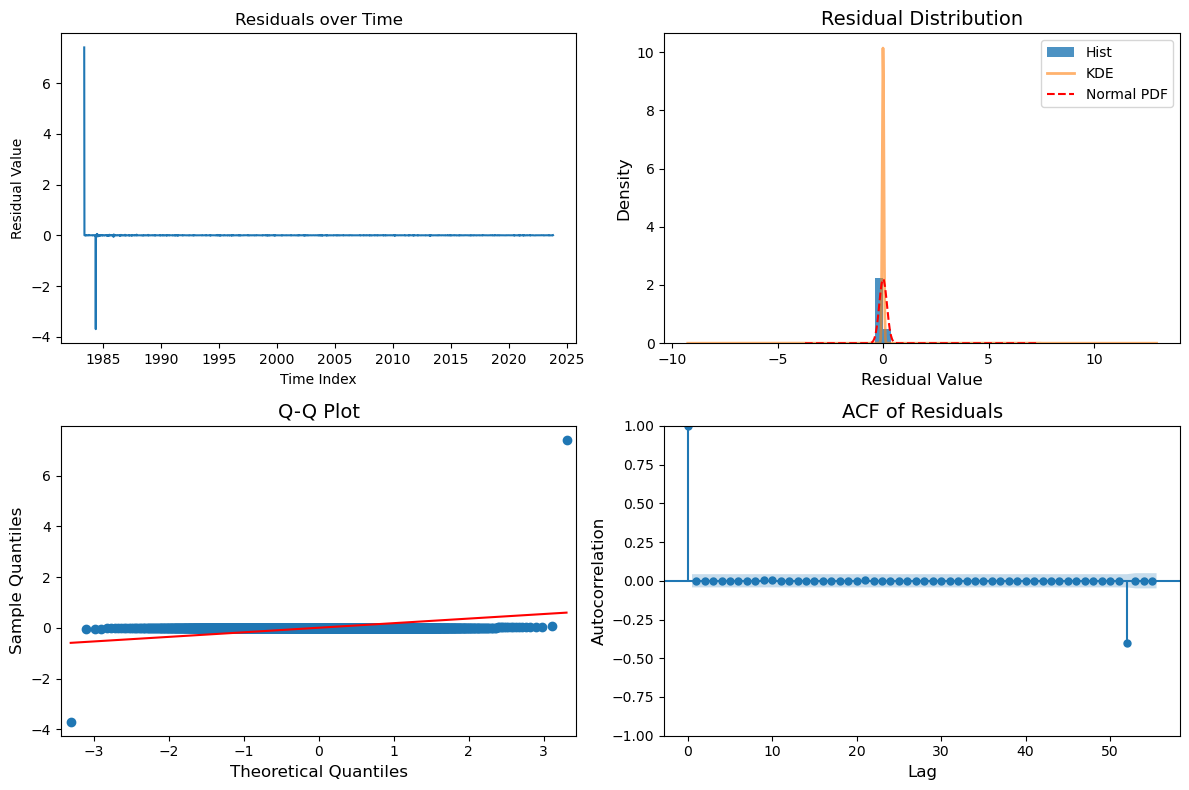


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.9728
lag 5: p = 1.0000
lag 10: p = 1.0000
lag 52: p = 0.0000


In [136]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.api import qqplot

def make_outlier_exog(index, outlier_dates):
    exog = pd.DataFrame(0, index=index, columns=[f'out_{i}' for i in range(len(outlier_dates))])
    for i, dt in enumerate(outlier_dates):
        if dt in index:
            exog.loc[dt, f'out_{i}'] = 1
        else:
            # if exact date not present (possible weekly freq), find nearest match
            nearest = index.get_indexer([dt], method='nearest')[0]
            exog.iloc[nearest, i] = 1
    return exog

initial = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c').fit(method='powell', disp=False)
init_resid = initial.resid.abs()
top_dates = init_resid.nlargest(5).index.tolist()
print(f'Top outlier dates: {top_dates}')

# create individual dummies, exogenous regressors, for the "outliers"
exog_train_indiv = make_outlier_exog(CH4_train_log_preprocessed.index, top_dates)

# the following code is the in_sample_resid_ansalysis function from model_evaluation.py, with included exog parameter
model = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                exog=exog_train_indiv,
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c')
results = model.fit(method='powell', disp=False)
residuals = results.resid

top_resid_df = init_resid.nlargest(5).to_frame(name='|Residual|')
top_resid_df.index.name = 'Date'

# show both signed and absolute values
signed_resid = initial.resid.loc[top_resid_df.index]
top_resid_df['Residual (Signed)'] = signed_resid

print('\nTop 5 residuals:')
print(top_resid_df)

# --- Plot residual diagnostics ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
# Residual time series
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuals over Time')
axes[0,0].set_xlabel('Time Index')
axes[0,0].set_ylabel('Residual Value')

# Histogram + KDE
axes[0,1].hist(residuals, bins=30, density=True, alpha=0.8, label='Hist')
residuals.plot(kind='kde', ax=axes[0,1], linewidth=2, alpha=0.6, label='KDE')

# Theoretical normal curve
x_vals = np.linspace(residuals.min(), residuals.max(), 200)
normal_pdf = stats.norm.pdf(x_vals, loc=residuals.mean(), scale=residuals.std())
axes[0,1].plot(x_vals, normal_pdf, color='r', linestyle='--', label='Normal PDF')
axes[0,1].set_title('Residual Distribution', fontsize=14)
axes[0,1].set_xlabel('Residual Value', fontsize=12)
axes[0,1].set_ylabel('Density', fontsize=12)
axes[0,1].legend()

# Q-Q plot
qqplot(residuals, line='s', ax=axes[1,0])
axes[1,0].set_title('Q-Q Plot', fontsize=14)
axes[1,0].set_xlabel('Theoretical Quantiles', fontsize=12)
axes[1,0].set_ylabel('Sample Quantiles', fontsize=12)

# ACF plot
plot_acf(residuals, lags=55, ax=axes[1,1])
axes[1,1].set_title('ACF of Residuals', fontsize=14)
axes[1,1].set_xlabel('Lag', fontsize=12)
axes[1,1].set_ylabel('Autocorrelation', fontsize=12)

plt.tight_layout()
plt.show()

# Ljung-Box test
lb = acorr_ljungbox(residuals, lags=[1,5,10,52], return_df=True)
print('\n--- Autocorrelation Diagnostics ---')
print('Ljung-Box Test')
print('H0: No autocorrelation up to specified lags')
for lag in [1,5,10,52]:
    print(f"lag {lag}: p = {lb.loc[lag, 'lb_pvalue']:.4f}")

In [130]:
# Two major spikes remain.  I will check the top 5 residuals again to verify that they are the same two
# early spikes seen prior to the SARIMAX model fit with exogenous dummy variables.  

print('Top 5 Residuals for Magnitude, Before and After Dummy Variables')
print('\nBefore dummy variables:')
print(init_resid.abs().nlargest(5))
print('\nAfter dummy variables:')
print(residuals.abs().nlargest(5))

Top 5 Residuals for Magnitude, Before and After Dummy Variables

Before dummy variables:
date
1983-05-08    7.400811
1984-05-06    3.702927
1988-12-18    0.365038
1988-12-25    0.128283
1985-11-24    0.080956
dtype: float64

After dummy variables:
date
1983-05-08    7.404007
1984-05-06    3.698867
1985-11-17    0.061678
1984-06-10    0.053787
1984-07-08    0.044161
dtype: float64


In [86]:
# Verify that all outlier dates exist in the train set index

for dt in top_dates:
    print(dt, dt in CH4_train_log_preprocessed.index)

1983-05-08 00:00:00 True
1984-05-06 00:00:00 True
1988-12-18 00:00:00 True
1988-12-25 00:00:00 True
1985-11-24 00:00:00 True


All outlier dates do exist in the train set and the dummy variables can be properly aligned to the exact observations in the train set.

In [87]:
# Verify that the exogenous variable matrix is correct

print(exog_train_indiv.sum())               # each column should sum to 1
print(exog_train_indiv.loc[top_dates])

out_0    1
out_1    1
out_2    1
out_3    1
out_4    1
dtype: int64
            out_0  out_1  out_2  out_3  out_4
date                                         
1983-05-08      1      0      0      0      0
1984-05-06      0      1      0      0      0
1988-12-18      0      0      1      0      0
1988-12-25      0      0      0      1      0
1985-11-24      0      0      0      0      1


The exogenous matrix is correct.  Each dummy column corresponds to the correct specific date.

In [121]:
# After fit `results`

# extract coefficients and standard errors for outlier dummy regressors
outlier_cols = [c for c in results.params.index if 'out' in c or 'outlier' in c]

# create a summary DataFrame
outlier_summary = pd.DataFrame({
    'Top Dates': top_dates,
    'Coefficient': results.params[outlier_cols],
    'Std. Error': results.bse[outlier_cols]  # standard errors of parameter estimates
})

# compute z-scores and two sided p-values
outlier_summary['z-score'] = outlier_summary['Coefficient'] / outlier_summary['Std. Error']
outlier_summary['p-value'] = 2 * (1 - stats.norm.cdf(np.abs(outlier_summary['z-score'])))

# pretty print
print('\nOutlier Regressor Coefficients Summary:')
print(outlier_summary.round(5).to_string())                 


Outlier Regressor Coefficients Summary:
       Top Dates  Coefficient  Std. Error   z-score  p-value
out_0 1983-05-08     -0.00320     0.00260  -1.22814  0.21940
out_1 1984-05-06     -0.00566     0.00225  -2.50942  0.01209
out_2 1988-12-18     -0.36281     0.01168 -31.06242  0.00000
out_3 1988-12-25     -0.00028     0.01183  -0.02378  0.98103
out_4 1985-11-24     -0.07240     0.00078 -93.38812  0.00000


The dummy variables captured two substantial residual shocks: 1988-12-18 (out_2) and 1985-11-24 (out_4)

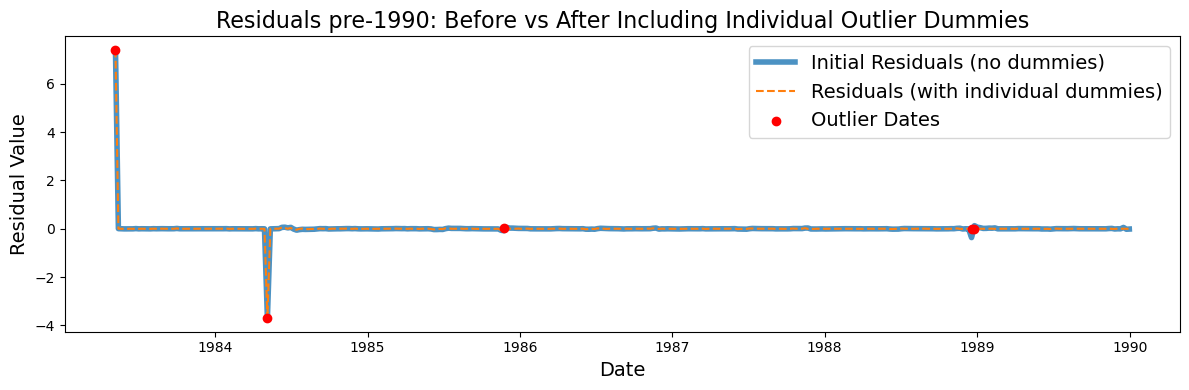

In [148]:
# Compare residuals before vs after including individual outlier dummies
plt.figure(figsize=(12, 4))
plt.plot(initial.resid.loc[:'1989'], label='Initial Residuals (no dummies)', linewidth=4, alpha=0.8)
plt.plot(results.resid.loc[:'1989'], label='Residuals (with individual dummies)', linestyle='--',alpha=1)

# Mark the top residual dates in red
plt.scatter(top_dates, results.resid.loc[top_dates], color='red', zorder=5, label='Outlier Dates')

plt.legend(fontsize=14)
plt.title('Residuals pre-1990: Before vs After Including Individual Outlier Dummies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.tight_layout()
plt.show()

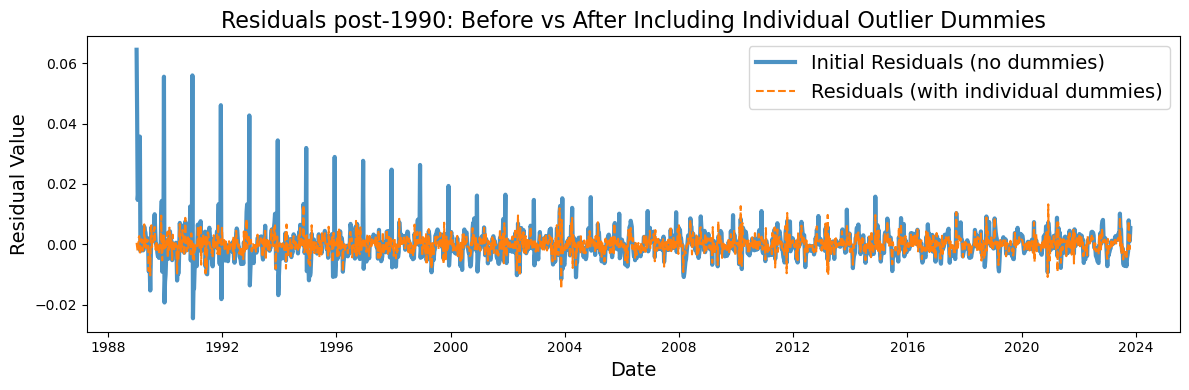

In [147]:
# Compare residuals before vs after including individual outlier dummies
plt.figure(figsize=(12, 4))
plt.plot(initial.resid.loc['1989':], label='Initial Residuals (no dummies)', linewidth=3, alpha=0.8)
plt.plot(results.resid.loc['1989':], label='Residuals (with individual dummies)', linestyle='--',alpha=1)

# Mark the top residual dates in red
# plt.scatter(top_dates, results.resid.loc[top_dates], color='red', zorder=5, label='Outlier Dates')

plt.legend(fontsize=14)
plt.title('Residuals post-1990: Before vs After Including Individual Outlier Dummies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.tight_layout()
plt.show()

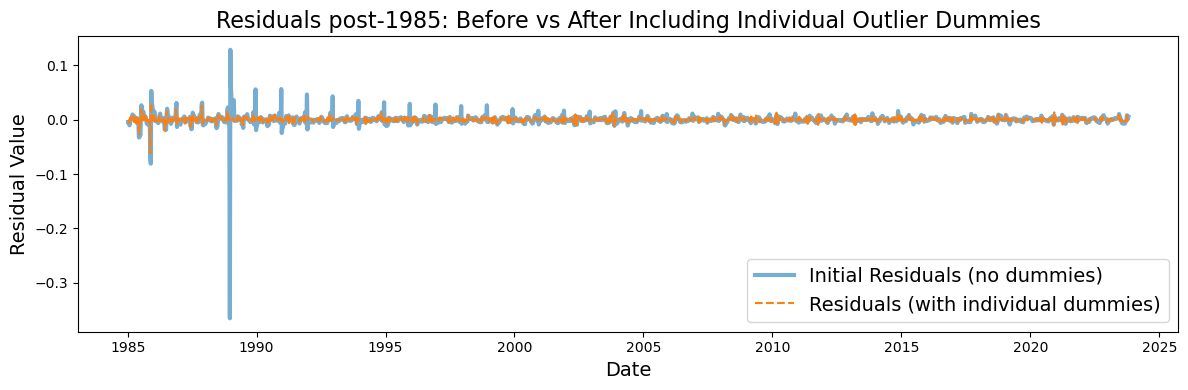

In [146]:
plt.figure(figsize=(12,4))
plt.plot(initial.resid.loc['1985':], label='Initial Residuals (no dummies)', linewidth=3, alpha=0.6)
plt.plot(results.resid.loc['1985':], label='Residuals (with individual dummies)', linestyle='--', alpha=1)

plt.legend(loc='lower right', fontsize=14)
plt.title('Residuals post-1985: Before vs After Including Individual Outlier Dummies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residual Value', fontsize=14)
plt.tight_layout()
plt.show()

Top outlier dates: [Timestamp('1983-05-08 00:00:00'), Timestamp('1984-05-06 00:00:00'), Timestamp('1988-12-18 00:00:00'), Timestamp('1988-12-25 00:00:00'), Timestamp('1985-11-24 00:00:00')]

Top 5 residuals:
            |Residual|  Residual (Signed)
Date                                     
1983-05-08    7.400811           7.400811
1984-05-06    3.702927          -3.702927
1988-12-18    0.365038          -0.365038
1988-12-25    0.128283           0.128283
1985-11-24    0.080956          -0.080956


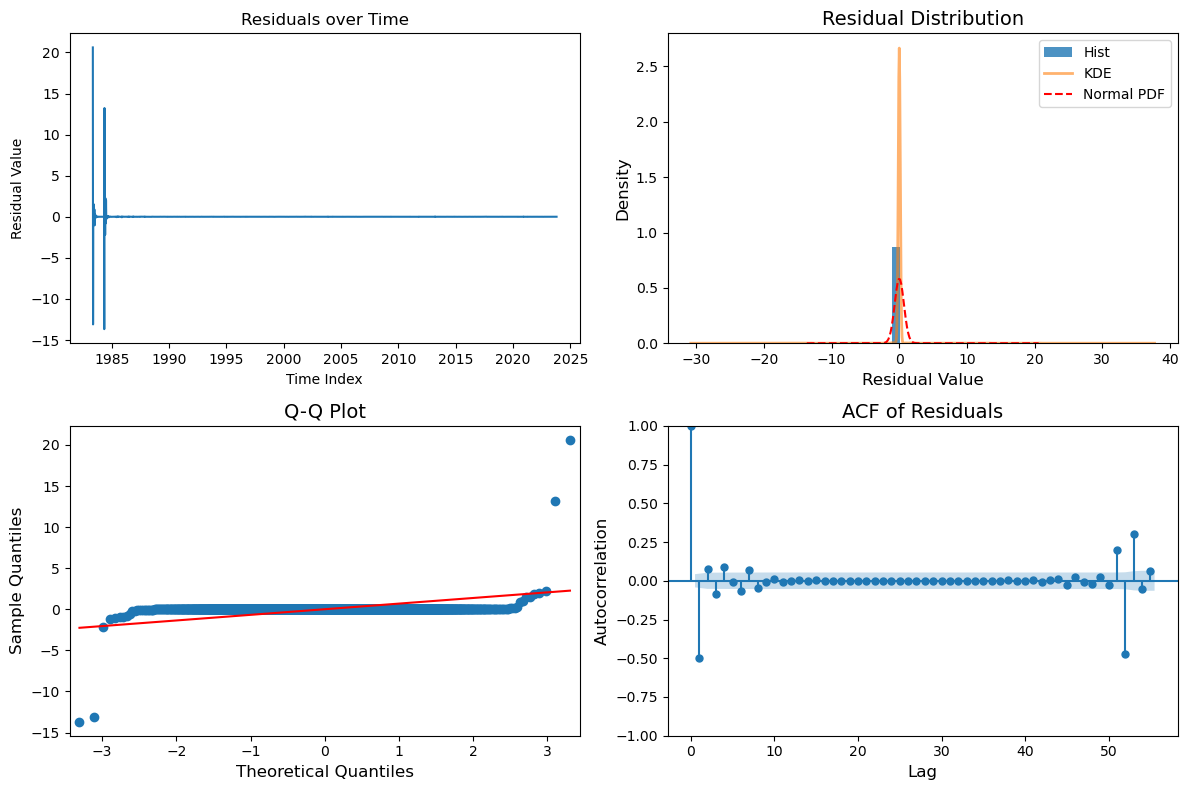


--- Autocorrelation Diagnostics ---
Ljung-Box Test
H0: No autocorrelation up to specified lags
lag 1: p = 0.0000
lag 5: p = 0.0000
lag 10: p = 0.0000
lag 52: p = 0.0000


In [135]:
def make_outlier_exog(index, outlier_dates):
    exog = pd.DataFrame(0, index=index, columns=[f'out_{i}' for i in range(len(outlier_dates))])
    for i, dt in enumerate(outlier_dates):
        if dt in index:
            exog.loc[dt, f'out_{i}'] = 1
        else:
            # if exact date not present (possible weekly freq), find nearest match
            nearest = index.get_indexer([dt], method='nearest')[0]
            exog.iloc[nearest, i] = 1
    return exog

initial = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c').fit(method='powell', disp=False)
init_resid = initial.resid.abs()
top_dates = init_resid.nlargest(5).index.tolist()
print(f'Top outlier dates: {top_dates}')

# create grouped dummy (one column) OR individual dummies
# grouped:
# exog_train_grouped = pd.DataFrame({'outlier_flag': 0}, index=train.index)
# exog_train_grouped.loc[top_dates, 'outlier_flag'] = 1

# create individual dummies
exog_train_indiv = make_outlier_exog(CH4_train_log_preprocessed.index, top_dates)

model = SARIMAX(CH4_train_log_preprocessed, 
                order=(7,1,0), 
                seasonal_order=(1,1,1,52),
                exog=exog_train_indiv,
                enforce_stationarity=True, 
                enforce_invertibility=True, 
                trend='c',
                initialization='diffuse')
results = model.fit(method='powell', disp=False)
residuals = results.resid

top_resid_df = init_resid.nlargest(5).to_frame(name='|Residual|')
top_resid_df.index.name = 'Date'

# show both signed and absolute values
signed_resid = initial.resid.loc[top_resid_df.index]
top_resid_df['Residual (Signed)'] = signed_resid

print('\nTop 5 residuals:')
print(top_resid_df)

# --- Plot residual diagnostics ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
# Residual time series
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuals over Time')
axes[0,0].set_xlabel('Time Index')
axes[0,0].set_ylabel('Residual Value')

# Histogram + KDE
axes[0,1].hist(residuals, bins=30, density=True, alpha=0.8, label='Hist')
residuals.plot(kind='kde', ax=axes[0,1], linewidth=2, alpha=0.6, label='KDE')

# Theoretical normal curve
x_vals = np.linspace(residuals.min(), residuals.max(), 200)
normal_pdf = stats.norm.pdf(x_vals, loc=residuals.mean(), scale=residuals.std())
axes[0,1].plot(x_vals, normal_pdf, color='r', linestyle='--', label='Normal PDF')
axes[0,1].set_title('Residual Distribution', fontsize=14)
axes[0,1].set_xlabel('Residual Value', fontsize=12)
axes[0,1].set_ylabel('Density', fontsize=12)
axes[0,1].legend()

# Q-Q plot
qqplot(residuals, line='s', ax=axes[1,0])
axes[1,0].set_title('Q-Q Plot', fontsize=14)
axes[1,0].set_xlabel('Theoretical Quantiles', fontsize=12)
axes[1,0].set_ylabel('Sample Quantiles', fontsize=12)

# ACF plot
plot_acf(residuals, lags=55, ax=axes[1,1])
axes[1,1].set_title('ACF of Residuals', fontsize=14)
axes[1,1].set_xlabel('Lag', fontsize=12)
axes[1,1].set_ylabel('Autocorrelation', fontsize=12)

plt.tight_layout()
plt.show()

# Ljung-Box test
lb = acorr_ljungbox(residuals, lags=[1,5,10,52], return_df=True)
print('\n--- Autocorrelation Diagnostics ---')
print('Ljung-Box Test')
print('H0: No autocorrelation up to specified lags')
for lag in [1,5,10,52]:
    print(f"lag {lag}: p = {lb.loc[lag, 'lb_pvalue']:.4f}")

# Save Best Model Parameters for Production

In [123]:
import json
from datetime import datetime

model_config_best = {
    'model_type': 'SARIMAX',
    'order': (7,1,0),
    'seasonal_order': (1,1,1,52),
    'trend': 'c',
    'enforce_stationarity': True,
    'enforce_invertibility': True,
    'training_data_range': {
        'start': CH4_train_log_preprocessed.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_log_preprocessed.index[-1].strftime('%Y-%m-%d')
    },
    'data_points': len(CH4_train_log_preprocessed),
    'data_frequency': 'W',  # Weekly
    'transformation': 'log',  # using log-transformed data
    'preprocessor_version': '1.0',  
    'cv_performance': {  # Store best CV metrics
        'RMSE_mean': 0.010205,
        'MAE_mean': 0.007906
    },
    'test_performance': {  # From final validation
        'RMSE_log': 0.004636,
        'MAE_log': 0.003592,
        'RMSE_original': 8.983181,
        'MAE_original': 6.971737
    },
    'selection_rationale': 'Best overall RMSE in both CV and test validation',
    'fit_method': 'powell',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

model_config_best_simple = {
    'model_type': 'SARIMAX',
    'order': (1,1,1),
    'seasonal_order': (0,1,1,52),
    'trend': 'c',
    'enforce_stationarity': True,
    'enforce_invertibility': True,
    'training_data_range': {
        'start': CH4_train_log_preprocessed.index[0].strftime('%Y-%m-%d'),
        'end': CH4_train_log_preprocessed.index[-1].strftime('%Y-%m-%d')
    },
    'data_points': len(CH4_train_log_preprocessed),
    'data_frequency': 'W',  # Weekly
    'transformation': 'log',  # using log-transformed data
    'preprocessor_version': '1.0',  
    'cv_performance': {  # Store best CV metrics
        'RMSE_mean': 0.010530,
        'MAE_mean': 0.008095
    },
    'test_performance': {
        'RMSE_log': 0.005097,
        'MAE_log': 0.003489,
        'RMSE_original': 9.868525,
        'MAE_original': 6.768671
    },
    'selection_rationale': 'Pareto-optimal balance of simplicity and performance',
    'fit_method': 'powell',
    'saved_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
}

# save as JSON file
with open('../results/CH4_train_best_model_config.json', 'w') as f:
    json.dump(model_config_best, f, indent=2)

with open('../results/CH4_train_best_simple_model_config.json', 'w') as f:
    json.dump(model_config_best_simple, f, indent=2)

print('CH4 best model configuration saved.  Re-fit in next notebook.')
print('CH4 best simple model configuration saved.  Re-fit in next notebook.')

CH4 best model configuration saved.  Re-fit in next notebook.
CH4 best simple model configuration saved.  Re-fit in next notebook.


**NOTE** 
- Check deepseek regarding saving the models for the entire dataset, not just the train set
- may want to produce the plots and analyze residuals of prediction vs test set in this notebook and treat the next notebook as just forecasting.  